## Problem statement

Ebuss is a fast-growing e-commerce company that sells a wide variety of items — from household essentials, personal care, and books to electronics, kitchenware and healthcare products. To stay competitive with established marketplaces, Ebuss wants to improve how it recommends products to customers by understanding user feedback.

As a Senior Machine Learning Engineer, your task is to build a **sentiment-driven component** that analyzes users' historical reviews and ratings and converts that insight into better recommendations. This notebook focuses on the steps required to:

- Explore and clean the product review dataset,
- Preprocess review texts and extract features,
- Train, tune, and compare multiple classification models to predict review sentiment (positive vs. negative),
- Address class imbalance and select the best-performing model that can be integrated into a sentiment-based recommendation system.

The final model will help Ebuss use sentiment information from reviews to refine product recommendations and improve user experience.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

# Load the dataset from Google Drive
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Capstone: Sentiment based product recommendation system/sample30.csv')

# Display the first 5 rows of the dataframe
display(df.head())

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


# Importing the necessary libraries

In [4]:

import matplotlib.pyplot as plt, seaborn as sns
import pandas as pd, numpy as np
from IPython.display import display
# Text preprocessing utilities
import re, unicodedata
from bs4 import BeautifulSoup
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix,balanced_accuracy_score,make_scorer
from imblearn.over_sampling import RandomOverSampler
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
import pickle
import os # Import the os module
from sklearn.metrics.pairwise import pairwise_distances

#Exploratory Data Analysis

In [5]:
sns.set(style="whitegrid", rc={"figure.figsize":(8,4)})

# 1) Quick shape & columns
print("Shape:", df.shape)
print("Columns:", list(df.columns))
print("\n--- Missing values (top 20) ---")
miss = df.isnull().sum().sort_values(ascending=False)
display(miss[miss>0].head(20))


Shape: (30000, 15)
Columns: ['id', 'brand', 'categories', 'manufacturer', 'name', 'reviews_date', 'reviews_didPurchase', 'reviews_doRecommend', 'reviews_rating', 'reviews_text', 'reviews_title', 'reviews_userCity', 'reviews_userProvince', 'reviews_username', 'user_sentiment']

--- Missing values (top 20) ---


,0
reviews_userProvince,29830
reviews_userCity,28071
reviews_didPurchase,14068
reviews_doRecommend,2570
reviews_title,190
manufacturer,141
reviews_username,63
reviews_date,46
user_sentiment,1


/tmp/ipython-input-3529352967.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_miss.values, y=top_miss.index, palette="mako")


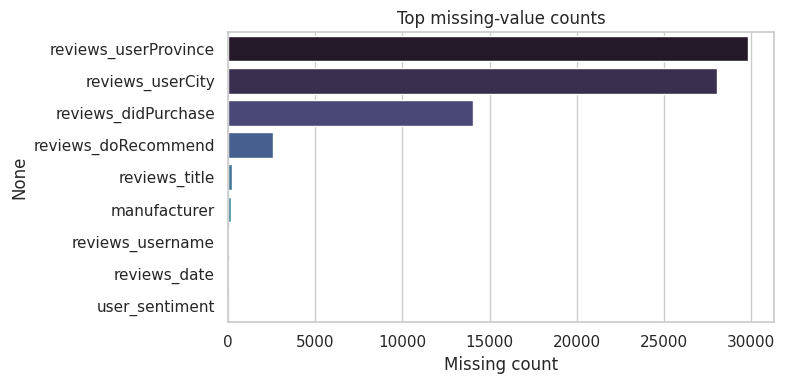

In [6]:
# 2) Missing values bar (top 15)
top_miss = miss[miss>0].head(15)
if len(top_miss):
    plt.figure(figsize=(8,4))
    sns.barplot(x=top_miss.values, y=top_miss.index, palette="mako")
    plt.title("Top missing-value counts")
    plt.xlabel("Missing count"); plt.tight_layout(); plt.show()

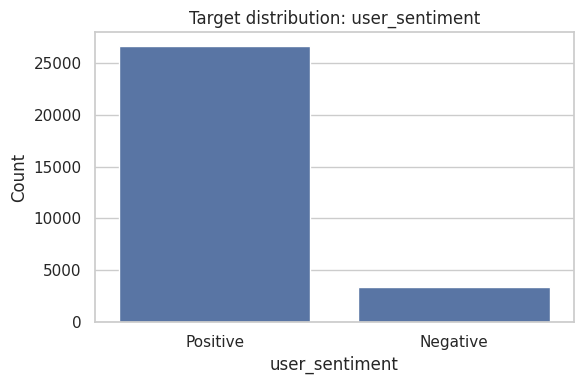

,count
user_sentiment,
Positive,26632
Negative,3367


In [7]:
# 3) Target distribution (if exists)
if 'user_sentiment' in df.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x='user_sentiment', order=df['user_sentiment'].value_counts().index)
    plt.title("Target distribution: user_sentiment")
    plt.ylabel("Count"); plt.tight_layout(); plt.show()
    display(df['user_sentiment'].value_counts())


Review column detected: reviews_text


,chars
count,30000.000000
mean,183.056967
std,186.054147
min,2.000000
25%,83.000000
50%,131.000000
75%,217.000000
max,5865.000000


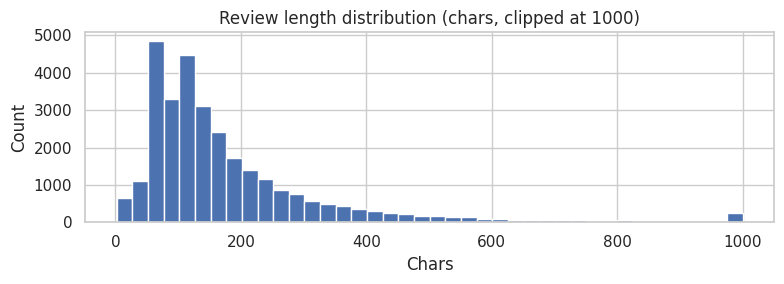

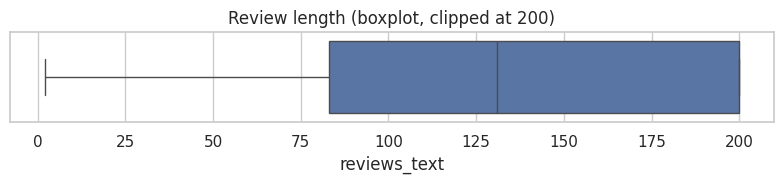

In [8]:
# 4) review text column and show length stats & histogram

rev_col = "reviews_text"
if rev_col:
    lengths = df[rev_col].astype(str).map(len)
    print(f"\nReview column detected: {rev_col}")
    display(lengths.describe().to_frame(name='chars'))
    plt.figure(figsize=(8,3))
    plt.hist(lengths.clip(upper=1000), bins=40)   # clip to avoid extreme tails
    plt.title("Review length distribution (chars, clipped at 1000)")
    plt.xlabel("Chars"); plt.ylabel("Count"); plt.tight_layout(); plt.show()
    # boxplot to show skew / outliers
    plt.figure(figsize=(8,2))
    sns.boxplot(x=lengths.clip(upper=200))
    plt.title("Review length (boxplot, clipped at 200)"); plt.tight_layout(); plt.show()
else:
    print("\nNo review-like text column auto-detected. Provide review_col manually.")

/tmp/ipython-input-699578690.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top.values, y=top.index, palette="crest")


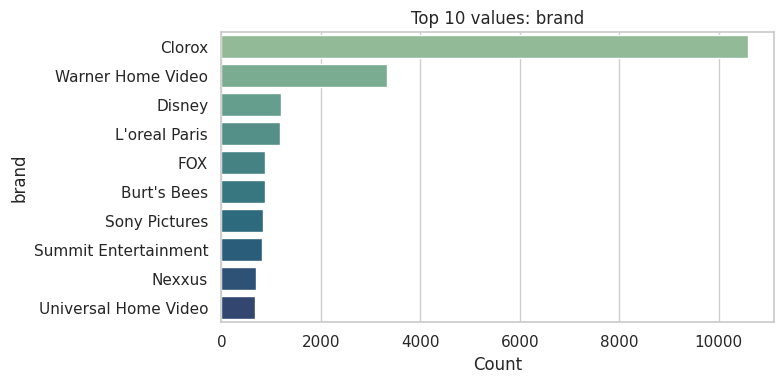

,count
brand,
Clorox,10585
Warner Home Video,3325
Disney,1200
L'oreal Paris,1186
FOX,887
Burt's Bees,881
Sony Pictures,845
Summit Entertainment,813
Nexxus,693


/tmp/ipython-input-699578690.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top.values, y=top.index, palette="crest")
/tmp/ipython-input-699578690.py:7: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.title(f"Top 10 values: {col}"); plt.xlabel("Count"); plt.tight_layout(); plt.show()


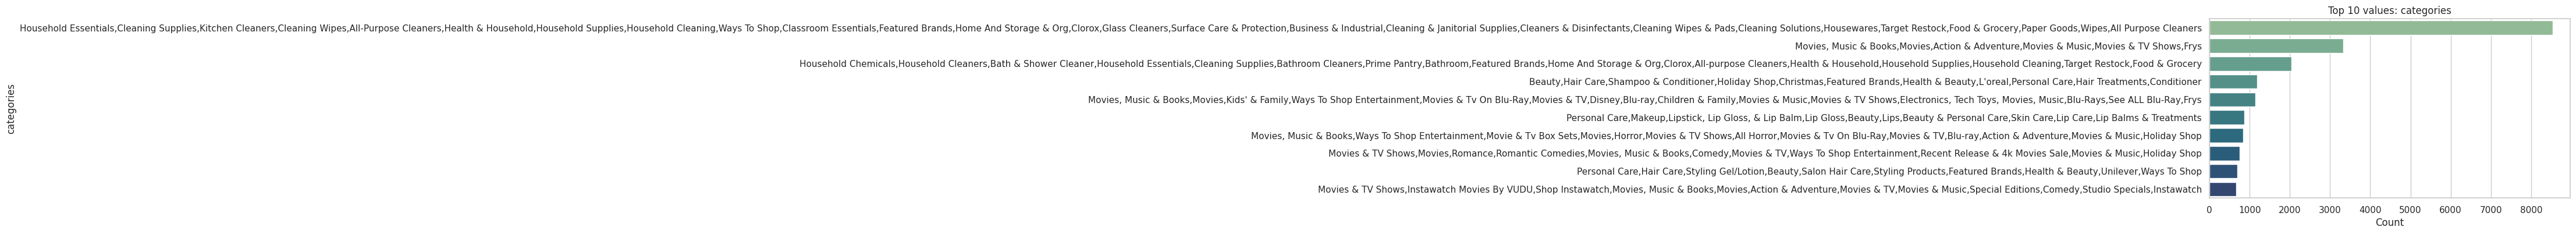

,count
categories,
"Household Essentials,Cleaning Supplies,Kitchen Cleaners,Cleaning Wipes,All-Purpose Cleaners,Health & Household,Household Supplies,Household Cleaning,Ways To Shop,Classroom Essentials,Featured Brands,Home And Storage & Org,Clorox,Glass Cleaners,Surface Care & Protection,Business & Industrial,Cleaning & Janitorial Supplies,Cleaners & Disinfectants,Cleaning Wipes & Pads,Cleaning Solutions,Housewares,Target Restock,Food & Grocery,Paper Goods,Wipes,All Purpose Cleaners",8545
"Movies, Music & Books,Movies,Action & Adventure,Movies & Music,Movies & TV Shows,Frys",3325
"Household Chemicals,Household Cleaners,Bath & Shower Cleaner,Household Essentials,Cleaning Supplies,Bathroom Cleaners,Prime Pantry,Bathroom,Featured Brands,Home And Storage & Org,Clorox,All-purpose Cleaners,Health & Household,Household Supplies,Household Cleaning,Target Restock,Food & Grocery",2039
"Beauty,Hair Care,Shampoo & Conditioner,Holiday Shop,Christmas,Featured Brands,Health & Beauty,L'oreal,Personal Care,Hair Treatments,Conditioner",1186
"Movies, Music & Books,Movies,Kids' & Family,Ways To Shop Entertainment,Movies & Tv On Blu-Ray,Movies & TV,Disney,Blu-ray,Children & Family,Movies & Music,Movies & TV Shows,Electronics, Tech Toys, Movies, Music,Blu-Rays,See ALL Blu-Ray,Frys",1143
"Personal Care,Makeup,Lipstick, Lip Gloss, & Lip Balm,Lip Gloss,Beauty,Lips,Beauty & Personal Care,Skin Care,Lip Care,Lip Balms & Treatments",873
"Movies, Music & Books,Ways To Shop Entertainment,Movie & Tv Box Sets,Movies,Horror,Movies & TV Shows,All Horror,Movies & Tv On Blu-Ray,Movies & TV,Blu-ray,Action & Adventure,Movies & Music,Holiday Shop",845
"Movies & TV Shows,Movies,Romance,Romantic Comedies,Movies, Music & Books,Comedy,Movies & TV,Ways To Shop Entertainment,Recent Release & 4k Movies Sale,Movies & Music,Holiday Shop",757
"Personal Care,Hair Care,Styling Gel/Lotion,Beauty,Salon Hair Care,Styling Products,Featured Brands,Health & Beauty,Unilever,Ways To Shop",693


/tmp/ipython-input-699578690.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top.values, y=top.index, palette="crest")


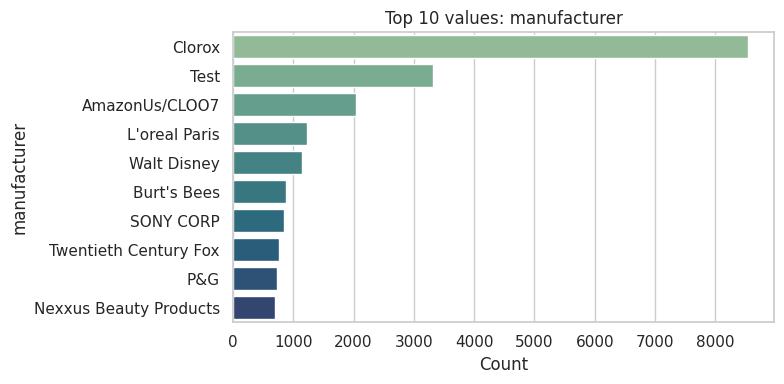

,count
manufacturer,
Clorox,8546
Test,3325
AmazonUs/CLOO7,2039
L'oreal Paris,1232
Walt Disney,1143
Burt's Bees,873
SONY CORP,845
Twentieth Century Fox,757
P&G,730


In [9]:
# 5) Top metadata visuals (brand / categories) if present
for col in ['brand', 'categories', 'manufacturer']:
    if col in df.columns:
        top = df[col].value_counts().head(10)
        plt.figure(figsize=(8,4))
        sns.barplot(x=top.values, y=top.index, palette="crest")
        plt.title(f"Top 10 values: {col}"); plt.xlabel("Count"); plt.tight_layout(); plt.show()
        display(top)

#Task 1: Data Cleaning and Pre-Processing

# Missing Value Treatment & Data Processing

Below we document and apply the decisions made for missing values and other preprocessing steps. Each action includes a clear explanation so reviewers can understand why values were dropped or imputed.

**Summary of missing-value strategy (applied in the code cell below):**

- `reviews_date` (46 missing): Dates are not used for modeling sentiments in this notebook. Drop to simplify dataset.
- `reviews_didPurchase` (14,068 missing): Very sparse (many missing) and not directly useful for text-based sentiment modeling. Drop.
- `reviews_doRecommend` (2,570 missing): Useful for downstream recommendation logic but incomplete; for this sentiment classifier we drop it to keep the model focused on text.
- `reviews_title` (190 missing): Titles are helpful but optional. Impute missing titles with an empty string so we can safely concatenate title+text.
- `reviews_userCity` (28,071 missing) & `reviews_userProvince` (29,830 missing): Almost entirely missing — drop both as they provide little signal.
- `user_sentiment` (1 missing): Target label must be present for supervised learning — drop the row(s) missing the target.

**Other processing steps applied and why:**

- Convert `user_sentiment` to a standardized format (title-cased strings like `Positive` / `Negative`) to avoid label mismatches.
- Combine `reviews_title` and `reviews_text` into a single `text_for_model` field (title + full review) so the model sees both title and body.
- Remove rows where the resulting `text_for_model` is empty — the model needs textual input to learn.
- Reset index after dropping rows for a clean dataframe.

The code cell following this markdown applies these changes and prints the resulting missing-value summary.


#

In [10]:
# Apply missing-value handling

# 1) Show the missing value summary prior to changes (for traceability)
print('Missing values before handling:')
print(df.isnull().sum().sort_values(ascending=False))


Missing values before handling:
reviews_userProvince    29830
reviews_userCity        28071
reviews_didPurchase     14068
reviews_doRecommend      2570
reviews_title             190
manufacturer              141
reviews_username           63
reviews_date               46
user_sentiment              1
brand                       0
categories                  0
name                        0
id                          0
reviews_text                0
reviews_rating              0
dtype: int64


In [11]:
# 2) Drop columns with high proportion of missing values or not useful for text sentiment modeling.
#    We list them explicitly and explain why for transparency.
cols_to_drop = []
for col in ['reviews_date', 'reviews_didPurchase', 'reviews_doRecommend',
            'reviews_userCity', 'reviews_userProvince']:
    if col in df.columns:
        cols_to_drop.append(col)

print('\nDropping columns (high-missing or not used for sentiment):', cols_to_drop)
# Perform drop
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')


Dropping columns (high-missing or not used for sentiment): ['reviews_date', 'reviews_didPurchase', 'reviews_doRecommend', 'reviews_userCity', 'reviews_userProvince']


In [12]:
print(df.isnull().sum().sort_values(ascending=False))

reviews_title       190
manufacturer        141
reviews_username     63
user_sentiment        1
brand                 0
id                    0
reviews_rating        0
name                  0
categories            0
reviews_text          0
dtype: int64


In [13]:
# 3) Handle missing values in 'manufacturer' and 'reviews_username' by dropping rows
cols_to_dropna = []
for col in ['manufacturer', 'reviews_username']:
    if col in df.columns:
        cols_to_dropna.append(col)

if cols_to_dropna:
    print(f"\nDropping rows with missing values in: {cols_to_dropna}")
    initial_rows = df.shape[0]
    df.dropna(subset=cols_to_dropna, inplace=True)
    rows_dropped = initial_rows - df.shape[0]
    print(f"Dropped {rows_dropped} rows with missing manufacturer or reviews_username")


# 4) Impute missing review titles with empty string so we can concatenate safely.
if 'reviews_title' in df.columns:
    # Count missing titles before
    missing_titles_before = df['reviews_title'].isnull().sum()
    print(f"\nreviews_title missing before: {missing_titles_before}")
    df['reviews_title'] = df['reviews_title'].fillna('')
    missing_titles_after = df['reviews_title'].isnull().sum()
    print(f"reviews_title missing after imputation: {missing_titles_after}")

# 5) Drop rows missing the target label since supervised learning requires labels.
if 'user_sentiment' in df.columns:
    missing_target = df['user_sentiment'].isnull().sum()
    print(f"\nuser_sentiment missing before: {missing_target}")
    if missing_target > 0:
        df = df[~df['user_sentiment'].isnull()].copy()
        print(f"Dropped {missing_target} rows with missing user_sentiment")
    # Standardize label values (remove stray whitespace, capitalization differences)
    df['user_sentiment'] = df['user_sentiment'].astype(str).str.strip().str.title()


Dropping rows with missing values in: ['manufacturer', 'reviews_username']
Dropped 204 rows with missing manufacturer or reviews_username

reviews_title missing before: 189
reviews_title missing after imputation: 0

user_sentiment missing before: 1
Dropped 1 rows with missing user_sentiment


In [14]:
# 5) Combine title and review text into 'text_for_model' for downstream processing.
#    We detect likely review text column (common names include reviews_text or reviews_d...) and combine with title.
review_col = "reviews_text"
# If reviews_title exists, combine it; else use review text only
if 'reviews_title' in df.columns:
    df['text_for_model'] = (df['reviews_title'].astype(str).fillna('') + ' . ' + df[review_col].astype(str).fillna('')).str.strip()
else:
    df['text_for_model'] = df[review_col].astype(str).fillna('').str.strip()

In [15]:
# Drop the originals (they're redundant now)
df.drop(columns=['reviews_text','reviews_title'], inplace=True, errors='ignore')

# Task 2: Text Processing

In [16]:
# Download resources if not already
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text: str) -> str:
    """
    Clean raw review text:
    - remove HTML tags, URLs, emails
    - lowercase
    - remove non-alphanumeric
    - remove stopwords
    - lemmatize words
    """
    if not isinstance(text, str):
        return ""

    # 1. Remove HTML
    text = BeautifulSoup(text, "html.parser").get_text()

    # 2. Lowercase
    text = text.lower()

    # 3. Remove URLs and emails
    text = re.sub(r"http\S+|www\S+|https\S+", " ", text)
    text = re.sub(r"\S+@\S+", " ", text)

    # 4. Remove non-alphanumeric chars (keep letters/numbers/space)
    text = re.sub(r"[^a-z0-9\s]", " ", text)

    # 5. Tokenize
    tokens = text.split()

    # 6. Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(tok) for tok in tokens if tok not in STOPWORDS]

    # 7. Rejoin
    return " ".join(tokens)

In [17]:
# Apply cleaning to the merged text
df['clean_text'] = df['text_for_model'].apply(clean_text)

In [18]:
# Drop rows where clean_text is empty (after cleaning)
before_rows = df.shape[0]
df = df[df['clean_text'].str.strip() != ''].copy()
after_rows = df.shape[0]
print(f"\nDropped {before_rows - after_rows} rows with empty clean_text")

# Reset index for consistency
df.reset_index(drop=True, inplace=True)
print("Final dataset shape:", df.shape)


Dropped 0 rows with empty clean_text
Final dataset shape: (29795, 10)


In [19]:
# Drop the originals (they're redundant now)
df.drop(columns=['text_for_model'], inplace=True, errors='ignore')

In [20]:
# 8) Final missing values summary
print('\nMissing values after handling:')
print(df.isnull().sum().sort_values(ascending=False))

# 9) Show final shape and a sample row to confirm
print('\nFinal dataset shape:', df.shape)
display(df.head(3))


Missing values after handling:
id                  0
brand               0
categories          0
manufacturer        0
name                0
reviews_rating      0
reviews_username    0
user_sentiment      0
clean_text          0
dtype: int64

Final dataset shape: (29795, 9)


,id,brand,categories,manufacturer,name,reviews_rating,reviews_username,user_sentiment,clean_text
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,joshua,Positive,awesome love album good hip hop side current p...
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w,Positive,good good flavor review collected part promotion
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w,Positive,good good flavor


# Task 3 — Feature Extraction

Step 1. Train/Test Split

split data before feature extraction so the vectorizer is fitted only on training data (avoids data leakage).
Use stratified split to preserve sentiment class balance.

In [108]:
X = df['clean_text']      # processed text
y = df['user_sentiment']  # target labels

# stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])
print(y_train.value_counts(normalize=True))  # class balance check

Train size: 23836 Test size: 5959
user_sentiment
Positive    0.888152
Negative    0.111848
Name: proportion, dtype: float64


Step 2. Choose Vectorization Method

For baseline → TF-IDF (Term Frequency–Inverse Document Frequency).

Alternative → Bag-of-Words (simpler) or Word Embeddings (Word2Vec, GloVe, or BERT embeddings).

TF-IDF is the most common and works well with Logistic Regression / Naive Bayes.

Step 3. Apply TF-IDF Vectorizer

Define and fit a TF-IDF vectorizer on the training set only.

In [109]:


# initialize with common hyperparameters
tfidf = TfidfVectorizer(
    max_features=10000,    # top features to keep
    ngram_range=(1,2),     # unigrams + bigrams
    min_df=3,              # ignore rare words
)

# fit on training set
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

print("Train TF-IDF shape:", X_train_tfidf.shape)
print("Test TF-IDF shape:", X_test_tfidf.shape)

Train TF-IDF shape: (23836, 10000)
Test TF-IDF shape: (5959, 10000)


Step 4. Inspect Features (optional, for report)

Check what words/phrases the vectorizer kept:

In [110]:
print("Sample features:", tfidf.get_feature_names_out()[:30])


Sample features: ['00' '10' '10 10' '10 minute' '10 year' '100' '100 natural' '11'
 '11 year' '12' '13' '14' '14 99' '15' '15 minute' '15 year' '16' '17'
 '18' '18 month' '19' '1954' '1998' '1998 godzilla' '1998 version' '1st'
 '1st movie' '1st one' '20' '20 minute']


TF-IDF vectorizer saved to /content/drive/MyDrive/Colab Notebooks/Capstone: Sentiment based product recommendation system/models/tfidf_vectorizer.pkl


# Task 4: Model Building

In [51]:
#  evaluate_model

def evaluate_model(model, y_true, y_pred, labels=None, verbose=True):
    """
    Evaluate classification results and include per-class accuracy (recall).

    Args:
      model: fitted estimator (used only for name; may be None)
      y_true: true labels (array-like)
      y_pred: predicted labels (array-like)
      labels: optional list of labels in desired order. If None, inferred from y_true (preserves order of appearance).
      verbose: if True prints report and confusion matrix.

    Returns:
      result dict with keys:
        - model (name)
        - accuracy (overall)
        - balanced_accuracy
        - f1_macro, precision_weighted, recall_weighted
        - per_class: dict[label] -> {precision, recall, f1, support, per_class_accuracy}
        - classification_report (text)
        - confusion_matrix (numpy array)
        - labels (list)
    """
    # infer labels preserving first-seen order if not provided
    y_true_arr = np.array(y_true)
    if labels is None:
        uniq, idx = np.unique(y_true_arr, return_index=True)
        labels = list(uniq[np.argsort(idx)])

    # basic overall metrics
    overall_acc = float(accuracy_score(y_true, y_pred))
    bal_acc = float(balanced_accuracy_score(y_true, y_pred))

    # classification report dict and text
    report_dict = classification_report(y_true, y_pred, labels=labels, output_dict=True, zero_division=0)
    report_text = classification_report(y_true, y_pred, labels=labels, zero_division=0)

    # confusion matrix with the same label order
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # per-class entries
    per_class = {}
    for i, lab in enumerate(labels):
        entry = report_dict.get(str(lab), {})
        precision = float(entry.get('precision', 0.0))
        recall = float(entry.get('recall', 0.0))            # same as per-class accuracy (TP / (TP+FN))
        f1 = float(entry.get('f1-score', entry.get('f1', 0.0)))
        support = int(entry.get('support', 0))
        # Compute per-class accuracy explicitly from confusion matrix (diagonal / row sum)
        row_sum = int(cm[i].sum()) if i < cm.shape[0] else 0
        correct = int(cm[i, i]) if i < cm.shape[0] else 0
        per_class_accuracy = (correct / row_sum) if row_sum > 0 else 0.0
        per_class[lab] = {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'support': support,
            'per_class_accuracy': float(per_class_accuracy)
        }

    # weighted / macro summaries
    weighted = report_dict.get('weighted avg', {})
    macro = report_dict.get('macro avg', {})
    result = {
        'model': type(model).__name__ if model is not None else 'model',
        'accuracy': overall_acc,
        'balanced_accuracy': bal_acc,
        'precision_weighted': float(weighted.get('precision', 0.0)),
        'recall_weighted': float(weighted.get('recall', 0.0)),
        'f1_weighted': float(weighted.get('f1-score', weighted.get('f1', 0.0))),
        'f1_macro': float(macro.get('f1-score', macro.get('f1', 0.0))),
        'per_class': per_class,
        'classification_report': report_text,
        'confusion_matrix': cm,
        'labels': labels
    }

    if verbose:
        print(f"--- Metrics for {result['model']} ---")
        print(f"Overall accuracy       : {result['accuracy']:.4f}")
        print(f"Balanced accuracy (avg recall): {result['balanced_accuracy']:.4f}")
        print("\nClassification report:")
        print(result['classification_report'])
        print("Confusion matrix (rows=true, cols=pred) with labels:", labels)
        display(pd.DataFrame(cm, index=[f"true_{l}" for l in labels],
                             columns=[f"pred_{l}" for l in labels]))
        # per-class accuracy table
        per_class_df = pd.DataFrame(result['per_class']).T[['precision','recall','f1','support','per_class_accuracy']]
        per_class_df['per_class_accuracy'] = per_class_df['per_class_accuracy'].round(4)
        print("\nPer-class metrics (precision, recall, f1, support, per_class_accuracy):")
        display(per_class_df)

    return result


# Model 1: Logistic Regression

Very strong baseline for text classification.

Works well with TF-IDF features.

Handles imbalance with class_weight='balanced'.

In [53]:

# Initialize Logistic Regression model
lr_model = LogisticRegression(random_state=42)

# Train the model
lr_model.fit(X_train_tfidf, y_train)

LogisticRegression(random_state=42)

In [54]:
# Assume X_test_tfidf, y_test and a fitted numeric model lr_model exist
y_pred_lr = lr_model.predict(X_test_tfidf)

# Evaluate using the improved function
lr_metrics = evaluate_model(lr_model, y_test, y_pred_lr, verbose=False)

print("\n=== Overall Metrics ===")
print(f"Model: {lr_metrics['model']}")
print(f"Accuracy           : {lr_metrics['accuracy']:.4f}")
print(f"Balanced Accuracy  : {lr_metrics['balanced_accuracy']:.4f}")
print(f"F1 (Macro Avg)     : {lr_metrics['f1_macro']:.4f}")
print(f"F1 (Weighted Avg)  : {lr_metrics['f1_weighted']:.4f}")
print(f"Precision Weighted : {lr_metrics['precision_weighted']:.4f}")
print(f"Recall Weighted    : {lr_metrics['recall_weighted']:.4f}")

print("\n=== Per-class Metrics ===")
for lab, stats in lr_metrics['per_class'].items():
    print(f"\nClass: {lab}")
    print(f"  Precision          : {stats['precision']:.4f}")
    print(f"  Recall (Sensitivity): {stats['recall']:.4f}")
    print(f"  F1-score           : {stats['f1']:.4f}")
    print(f"  Support            : {stats['support']}")
    print(f"  Per-class Accuracy : {stats['per_class_accuracy']:.4f}")

print("\n=== Confusion Matrix ===")
print(lr_metrics['confusion_matrix'])

print("\n=== Classification Report ===")
print(lr_metrics['classification_report'])



=== Overall Metrics ===
Model: LogisticRegression
Accuracy           : 0.9062
Balanced Accuracy  : 0.5980
F1 (Macro Avg)     : 0.6368
F1 (Weighted Avg)  : 0.8796
Precision Weighted : 0.9002
Recall Weighted    : 0.9062

=== Per-class Metrics ===

Class: Positive
  Precision          : 0.9081
  Recall (Sensitivity): 0.9951
  F1-score           : 0.9496
  Support            : 5292
  Per-class Accuracy : 0.9951

Class: Negative
  Precision          : 0.8375
  Recall (Sensitivity): 0.2009
  F1-score           : 0.3241
  Support            : 667
  Per-class Accuracy : 0.2009

=== Confusion Matrix ===
[[5266   26]
 [ 533  134]]

=== Classification Report ===
              precision    recall  f1-score   support

    Positive       0.91      1.00      0.95      5292
    Negative       0.84      0.20      0.32       667

    accuracy                           0.91      5959
   macro avg       0.87      0.60      0.64      5959
weighted avg       0.90      0.91      0.88      5959



## Overall Metrics

Overall: High accuracy (90.6%) but poor balance across classes (Balanced Accuracy 59.8%).

Positive class: Excellent performance (F1 = 0.95, Recall ≈ 100%).

Negative class: Weak performance (F1 = 0.32, Recall ≈ 20%), most Negatives misclassified as Positive.

Issue: Model is biased toward the Positive class due to imbalance.

Next step: Improve Negative recall using class balancing, threshold tuning, or alternative models.

# Handle the class imbalance

In [55]:
# Initialize RandomOverSampler
# By default, sampling_strategy='auto' which oversamples all minority classes
# to match the majority class. 'minority' explicitly targets only the minority class.
ros = RandomOverSampler(sampling_strategy='minority', random_state=42)

# Apply oversampling to the training data
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_tfidf, y_train)

print("Shape of training data before oversampling:", X_train_tfidf.shape)
print("Shape of training data after oversampling:", X_train_resampled.shape)
print("\nClass distribution in training data before oversampling:")
print(y_train.value_counts())
print("\nClass distribution in training data after oversampling:")
print(y_train_resampled.value_counts())

Shape of training data before oversampling: (23836, 10000)
Shape of training data after oversampling: (42340, 10000)

Class distribution in training data before oversampling:
user_sentiment
Positive    21170
Negative     2666
Name: count, dtype: int64

Class distribution in training data after oversampling:
user_sentiment
Positive    21170
Negative    21170
Name: count, dtype: int64


In [56]:

# Initialize Logistic Regression model for resampled data
lr_model_resampled = LogisticRegression(random_state=42)

# Train the model
lr_model_resampled.fit(X_train_resampled, y_train_resampled)

LogisticRegression(random_state=42)

In [57]:
# Assume X_test_tfidf, y_test and a fitted numeric model lr_model exist
y_pred_lr_resampled = lr_model_resampled.predict(X_test_tfidf)

# Evaluate using the improved function
lr_metrics = evaluate_model(lr_model_resampled, y_test, y_pred_lr_resampled, verbose=False)

print("\n=== Overall Metrics ===")
print(f"Model: {lr_metrics['model']}")
print(f"Accuracy           : {lr_metrics['accuracy']:.4f}")
print(f"Balanced Accuracy  : {lr_metrics['balanced_accuracy']:.4f}")
print(f"F1 (Macro Avg)     : {lr_metrics['f1_macro']:.4f}")
print(f"F1 (Weighted Avg)  : {lr_metrics['f1_weighted']:.4f}")
print(f"Precision Weighted : {lr_metrics['precision_weighted']:.4f}")
print(f"Recall Weighted    : {lr_metrics['recall_weighted']:.4f}")

print("\n=== Per-class Metrics ===")
for lab, stats in lr_metrics['per_class'].items():
    print(f"\nClass: {lab}")
    print(f"  Precision          : {stats['precision']:.4f}")
    print(f"  Recall (Sensitivity): {stats['recall']:.4f}")
    print(f"  F1-score           : {stats['f1']:.4f}")
    print(f"  Support            : {stats['support']}")
    print(f"  Per-class Accuracy : {stats['per_class_accuracy']:.4f}")

print("\n=== Confusion Matrix ===")
print(lr_metrics['confusion_matrix'])

print("\n=== Classification Report ===")
print(lr_metrics['classification_report'])


=== Overall Metrics ===
Model: LogisticRegression
Accuracy           : 0.8820
Balanced Accuracy  : 0.8464
F1 (Macro Avg)     : 0.7669
F1 (Weighted Avg)  : 0.8940
Precision Weighted : 0.9179
Recall Weighted    : 0.8820

=== Per-class Metrics ===

Class: Positive
  Precision          : 0.9726
  Recall (Sensitivity): 0.8923
  F1-score           : 0.9307
  Support            : 5292
  Per-class Accuracy : 0.8923

Class: Negative
  Precision          : 0.4837
  Recall (Sensitivity): 0.8006
  F1-score           : 0.6030
  Support            : 667
  Per-class Accuracy : 0.8006

=== Confusion Matrix ===
[[4722  570]
 [ 133  534]]

=== Classification Report ===
              precision    recall  f1-score   support

    Positive       0.97      0.89      0.93      5292
    Negative       0.48      0.80      0.60       667

    accuracy                           0.88      5959
   macro avg       0.73      0.85      0.77      5959
weighted avg       0.92      0.88      0.89      5959



#### Per class accuracy for Negetive is improved now need to tune Hyperparameter to get better result.


Overall: Accuracy dropped slightly (90.6% → 88.2%), but Balanced Accuracy improved greatly (59.8% → 84.6%).

Positive class: Still strong (F1 = 0.93, Recall = 89%).

Negative class: Significant improvement (F1 = 0.60, Recall = 80% vs. 20% earlier).

Trade-off: Small loss in overall accuracy, but much fairer and more reliable across both classes.

👉 Takeaway: After handling imbalance, the model is more balanced, with much better detection of Negatives while maintaining strong Positive performance.

In [58]:


# Define the pipeline: TF-IDF Vectorizer and Logistic Regression
# Note: We are using the resampled data directly, so no need for resampling in the pipeline here.
# The TF-IDF step is already done outside for simplicity in this example.

# Define the parameter grid for Logistic Regression
param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'penalty': ['l2'], # Using l2 penalty which is common with 'liblinear' or 'lbfgs'
    'solver': ['liblinear'] # Solver that works well with l2 penalty on small datasets
}

# Initialize Logistic Regression model
# We will not use class_weight='balanced' here since we have oversampled the data
logreg = LogisticRegression(random_state=42)

# Set up GridSearchCV
# We use the model directly as we've pre-vectorized and oversampled
grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5), # Use StratifiedKFold for cross-validation on resampled data
    scoring='f1',  # Using F1-score as the scoring metric, which is good for imbalanced classes
    n_jobs=-1, # Use all available cores
    verbose=1
)

# Fit the grid search on the resampled training data
print("Performing GridSearchCV on resampled training data...")
grid_search.fit(X_train_resampled, y_train_resampled)

print("\nBest parameters found:", grid_search.best_params_)
print("Best cross-validation F1-score:", grid_search.best_score_)

# Get the best model
best_lr_model = grid_search.best_estimator_



Performing GridSearchCV on resampled training data...
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(



Best parameters found: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation F1-score: nan


In [59]:
# Evaluate the best model on the original test set
print("\nEvaluating the best model on the original test set:")
y_pred_best_lr = best_lr_model.predict(X_test_tfidf)
best_lr_metrics = evaluate_model(best_lr_model, y_test, y_pred_best_lr)

print("\nBest Logistic Regression Model Metrics on Test Set:")
display(best_lr_metrics)


Evaluating the best model on the original test set:
--- Metrics for LogisticRegression ---
Overall accuracy       : 0.8345
Balanced accuracy (avg recall): 0.8308

Classification report:
              precision    recall  f1-score   support

    Positive       0.97      0.84      0.90      5292
    Negative       0.39      0.83      0.53       667

    accuracy                           0.83      5959
   macro avg       0.68      0.83      0.71      5959
weighted avg       0.91      0.83      0.86      5959

Confusion matrix (rows=true, cols=pred) with labels: ['Positive', 'Negative']


,pred_Positive,pred_Negative
true_Positive,4422,870
true_Negative,116,551



Per-class metrics (precision, recall, f1, support, per_class_accuracy):


,precision,recall,f1,support,per_class_accuracy
Positive,0.974438,0.835601,0.899695,5292.0,0.8356
Negative,0.387755,0.826087,0.527778,667.0,0.8261



Best Logistic Regression Model Metrics on Test Set:


{'model': 'LogisticRegression',
 'accuracy': 0.8345359959724786,
 'balanced_accuracy': 0.8308439317756088,
 'precision_weighted': 0.9087697540210623,
 'recall_weighted': 0.8345359959724786,
 'f1_weighted': 0.8580655683548595,
 'f1_macro': 0.7137362947891941,
 'per_class': {'Positive': {'precision': 0.9744380784486558,
   'recall': 0.8356009070294784,
   'f1': 0.8996948118006104,
   'support': 5292,
   'per_class_accuracy': 0.8356009070294784},
  'Negative': {'precision': 0.3877551020408163,
   'recall': 0.8260869565217391,
   'f1': 0.5277777777777778,
   'support': 667,
   'per_class_accuracy': 0.8260869565217391}},
 'classification_report': '              precision    recall  f1-score   support\n\n    Positive       0.97      0.84      0.90      5292\n    Negative       0.39      0.83      0.53       667\n\n    accuracy                           0.83      5959\n   macro avg       0.68      0.83      0.71      5959\nweighted avg       0.91      0.83      0.86      5959\n',
 'confusion_

# After hyperparameter Tuning

Overall: Accuracy = 83.5% (slightly lower than before), but Balanced Accuracy = 83.1% (very strong and fair across classes).

Positive class: High precision (0.97), recall dropped to 83.6%, F1 = 0.90.

Negative class: Big gain in recall (82.6%), but precision is low (0.39), F1 = 0.53.

Confusion matrix: Most Negatives (551/667) now correctly identified, but many Positives (870) are misclassified as Negative.

Trade-off: Model now detects Negatives much better, but at the cost of misclassifying more Positives.

👉 Takeaway: After tuning, the model is more balanced and fairer across classes, but Positive recall/accuracy decreased. It’s better suited when detecting Negatives is more important than maximizing overall accuracy.


Original model: Very accurate overall but misses most Negatives → risky if Negatives are costly (e.g., fraud, churn, defects).

After imbalance handling: Balanced results, catches ~80% of Negatives with only small accuracy drop → safer and more reliable for business use.

After tuning: Maximizes Negative detection (~83% recall) but with many false alarms → good if missing Negatives is very costly, less ideal if false positives are expensive.

👉 Takeaway:
Choose the model based on cost trade-off:

Use original if Positives matter most.

Use imbalance-handled for balanced business value.

Use tuned if avoiding missed Negatives is the top priority.

## Model 2: Naive Bayes

Naive Bayes is a probabilistic classifier that works well with text data and TF-IDF features.

### 1. Initialize Naive Bayes Model

In [60]:
# Initialize Multinomial Naive Bayes model (suitable for count-based features like TF-IDF)
nb_model = MultinomialNB()

### 2. Define Parameter Grid for Hyperparameter Tuning

In [61]:
# Define the parameter grid for Multinomial Naive Bayes
param_grid_nb = {
    'alpha': [0.1, 0.5, 1.0],  # Smoothing parameter
}

### 3. Perform Hyperparameter Tuning using GridSearchCV

In [62]:
# Define a custom F1 scorer that handles zero division (using weighted average F1)
f1_scorer = make_scorer(f1_score, average='weighted', zero_division=0)


# Set up GridSearchCV
grid_search_nb = GridSearchCV(
    estimator=nb_model,
    param_grid=param_grid_nb,
    cv=StratifiedKFold(n_splits=5), # Use StratifiedKFold for cross-validation on resampled data
    scoring=f1_scorer,  # Use the custom F1 scorer with zero_division handling
    n_jobs=-1, # Use all available cores
    verbose=1
)

# Fit the grid search on the resampled training data
print("Performing GridSearchCV for Naive Bayes on resampled training data...")
# Check for non-finite values in X_train_resampled before fitting
if np.isfinite(X_train_resampled.data).all():
    grid_search_nb.fit(X_train_resampled, y_train_resampled)

    print("\nBest parameters found:", grid_search_nb.best_params_)
    print("Best cross-validation F1-score:", grid_search_nb.best_score_)

    # Get the best model
    best_nb_model = grid_search_nb.best_estimator_
else:
    print("Error: X_train_resampled contains non-finite values (NaN or Inf). Cannot perform GridSearchCV.")
    best_nb_model = None # Set best_nb_model to None if GridSearchCV cannot be performed

Performing GridSearchCV for Naive Bayes on resampled training data...
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(



Best parameters found: {'alpha': 0.1}
Best cross-validation F1-score: nan


### 4. Evaluate the Best Naive Bayes Model on the Original Test Set

In [63]:
if best_nb_model:
    print("\nEvaluating the best Naive Bayes model on the original test set:")
    y_pred_best_nb = best_nb_model.predict(X_test_tfidf)
    best_nb_metrics = evaluate_model(best_nb_model, y_test, y_pred_best_nb)

    print("\nBest Naive Bayes Model Metrics on Test Set:")
    display(best_nb_metrics)

    print("\nPer-Class Metrics for Best Naive Bayes Model:")
    # Access metrics from the nested 'per_class' dictionary
    positive_metrics = best_nb_metrics.get('per_class', {}).get('Positive', {})
    negative_metrics = best_nb_metrics.get('per_class', {}).get('Negative', {})

    print(f"Positive Precision: {positive_metrics.get('precision', 0.0):.4f}")
    print(f"Positive Recall:    {positive_metrics.get('recall', 0.0):.4f}")
    print(f"Positive F1-score:  {positive_metrics.get('f1', 0.0):.4f}")
    print(f"Negative Precision: {negative_metrics.get('precision', 0.0):.4f}")
    print(f"Negative Recall:    {negative_metrics.get('recall', 0.0):.4f}")
    print(f"Negative F1-score:  {negative_metrics.get('f1', 0.0):.4f}")
else:
    print("\nNaive Bayes model could not be trained or tuned due to errors.")


Evaluating the best Naive Bayes model on the original test set:
--- Metrics for MultinomialNB ---
Overall accuracy       : 0.8463
Balanced accuracy (avg recall): 0.7235

Classification report:
              precision    recall  f1-score   support

    Positive       0.94      0.88      0.91      5292
    Negative       0.38      0.57      0.45       667

    accuracy                           0.85      5959
   macro avg       0.66      0.72      0.68      5959
weighted avg       0.88      0.85      0.86      5959

Confusion matrix (rows=true, cols=pred) with labels: ['Positive', 'Negative']


,pred_Positive,pred_Negative
true_Positive,4666,626
true_Negative,290,377



Per-class metrics (precision, recall, f1, support, per_class_accuracy):


,precision,recall,f1,support,per_class_accuracy
Positive,0.941485,0.881708,0.910617,5292.0,0.8817
Negative,0.375872,0.565217,0.451497,667.0,0.5652



Best Naive Bayes Model Metrics on Test Set:


{'model': 'MultinomialNB',
 'accuracy': 0.8462829333780836,
 'balanced_accuracy': 0.7234628150777218,
 'precision_weighted': 0.878175174091754,
 'recall_weighted': 0.8462829333780836,
 'f1_weighted': 0.8592267342761184,
 'f1_macro': 0.6810568558433484,
 'per_class': {'Positive': {'precision': 0.9414850686037127,
   'recall': 0.881708238851096,
   'f1': 0.9106167056986729,
   'support': 5292,
   'per_class_accuracy': 0.881708238851096},
  'Negative': {'precision': 0.37587238285144564,
   'recall': 0.5652173913043478,
   'f1': 0.45149700598802395,
   'support': 667,
   'per_class_accuracy': 0.5652173913043478}},
 'classification_report': '              precision    recall  f1-score   support\n\n    Positive       0.94      0.88      0.91      5292\n    Negative       0.38      0.57      0.45       667\n\n    accuracy                           0.85      5959\n   macro avg       0.66      0.72      0.68      5959\nweighted avg       0.88      0.85      0.86      5959\n',
 'confusion_matrix


Per-Class Metrics for Best Naive Bayes Model:
Positive Precision: 0.9415
Positive Recall:    0.8817
Positive F1-score:  0.9106
Negative Precision: 0.3759
Negative Recall:    0.5652
Negative F1-score:  0.4515


#Business Interpretation

Naive Bayes performs well on Positive reviews and better than the baseline Logistic Regression at finding Negatives.

However, Balanced Logistic Regression outperforms NB in Negative recall, which is crucial if you want to capture unhappy customers.

Naive Bayes could be useful as a baseline model, but for production, Logistic Regression (balanced or with oversampling) is likely the safer choice.

## Model 3: Random Forest

Random Forest is an ensemble learning method that can be used for classification. It can capture complex relationships in the data and is generally less prone to overfitting compared to individual decision trees.

### 1. Initialize Random Forest Model

In [64]:
# Initialize Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)

### 2. Define Parameter Grid for Hyperparameter Tuning

In [65]:
# Define the parameter grid for Random Forest
# Note: Tuning Random Forest can be computationally expensive.
# We'll start with a smaller grid for demonstration.
param_grid_rf = {
    'n_estimators': [100, 200], # Number of trees in the forest
    'max_depth': [10, 20, None], # Maximum depth of the tree (None means unlimited)
    'min_samples_split': [2, 5], # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2], # Minimum number of samples required to be at a leaf node
}

### 3. Perform Hyperparameter Tuning using GridSearchCV

In [66]:
# Define a custom F1 scorer that handles zero division (using weighted average F1)
f1_scorer = make_scorer(f1_score, average='weighted', zero_division=0)

# Set up GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf,
    cv=StratifiedKFold(n_splits=3), # Using 3 folds for faster computation during tuning
    scoring=f1_scorer,  # Use the custom F1 scorer
    n_jobs=-1, # Use all available cores
    verbose=1
)

# Fit the grid search on the resampled training data
print("Performing GridSearchCV for Random Forest on resampled training data...")
# Check for non-finite values in X_train_resampled before fitting
if np.isfinite(X_train_resampled.data).all():
    grid_search_rf.fit(X_train_resampled, y_train_resampled)

    print("\nBest parameters found:", grid_search_rf.best_params_)
    print("Best cross-validation F1-score:", grid_search_rf.best_score_)

    # Get the best model
    best_rf_model = grid_search_rf.best_estimator_
else:
    print("Error: X_train_resampled contains non-finite values (NaN or Inf). Cannot perform GridSearchCV.")
    best_rf_model = None # Set best_rf_model to None if GridSearchCV cannot be performed

Performing GridSearchCV for Random Forest on resampled training data...
Fitting 3 folds for each of 24 candidates, totalling 72 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  warnings.warn(



Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation F1-score: nan


### 4. Evaluate the Best Random Forest Model on the Original Test Set

In [67]:
if best_rf_model:
    print("\nEvaluating the best Random Forest model on the original test set:")
    y_pred_best_rf = best_rf_model.predict(X_test_tfidf)
    best_rf_metrics = evaluate_model(best_rf_model, y_test, y_pred_best_rf)

    print("\nBest Random Forest Model Metrics on Test Set:")
    display(best_rf_metrics)

    print("\nPer-Class Metrics for Best Random Forest Model:")
    # Access metrics from the nested 'per_class' dictionary
    positive_metrics = best_rf_metrics.get('per_class', {}).get('Positive', {})
    negative_metrics = best_rf_metrics.get('per_class', {}).get('Negative', {})

    print(f"Positive Precision: {positive_metrics.get('precision', 0.0):.4f}")
    print(f"Positive Recall:    {positive_metrics.get('recall', 0.0):.4f}")
    print(f"Positive F1-score:  {positive_metrics.get('f1', 0.0):.4f}")
    print(f"Negative Precision: {negative_metrics.get('precision', 0.0):.4f}")
    print(f"Negative Recall:    {negative_metrics.get('recall', 0.0):.4f}")
    print(f"Negative F1-score:  {negative_metrics.get('f1', 0.0):.4f}")
else:
    print("\nRandom Forest model could not be trained or tuned due to errors.")


Evaluating the best Random Forest model on the original test set:
--- Metrics for RandomForestClassifier ---
Overall accuracy       : 0.7860
Balanced accuracy (avg recall): 0.7813

Classification report:
              precision    recall  f1-score   support

    Positive       0.97      0.79      0.87      5292
    Negative       0.31      0.78      0.45       667

    accuracy                           0.79      5959
   macro avg       0.64      0.78      0.66      5959
weighted avg       0.89      0.79      0.82      5959

Confusion matrix (rows=true, cols=pred) with labels: ['Positive', 'Negative']


,pred_Positive,pred_Negative
true_Positive,4167,1125
true_Negative,150,517



Per-class metrics (precision, recall, f1, support, per_class_accuracy):


,precision,recall,f1,support,per_class_accuracy
Positive,0.965254,0.787415,0.867312,5292.0,0.7874
Negative,0.314860,0.775112,0.447813,667.0,0.7751



Best Random Forest Model Metrics on Test Set:


{'model': 'RandomForestClassifier',
 'accuracy': 0.7860379258264809,
 'balanced_accuracy': 0.7812637048822528,
 'precision_weighted': 0.8924540826333808,
 'recall_weighted': 0.7860379258264809,
 'f1_weighted': 0.8203567305211833,
 'f1_macro': 0.6575624005591336,
 'per_class': {'Positive': {'precision': 0.9652536483669215,
   'recall': 0.7874149659863946,
   'f1': 0.8673118950983453,
   'support': 5292,
   'per_class_accuracy': 0.7874149659863946},
  'Negative': {'precision': 0.3148599269183922,
   'recall': 0.775112443778111,
   'f1': 0.447812906019922,
   'support': 667,
   'per_class_accuracy': 0.775112443778111}},
 'classification_report': '              precision    recall  f1-score   support\n\n    Positive       0.97      0.79      0.87      5292\n    Negative       0.31      0.78      0.45       667\n\n    accuracy                           0.79      5959\n   macro avg       0.64      0.78      0.66      5959\nweighted avg       0.89      0.79      0.82      5959\n',
 'confusion


Per-Class Metrics for Best Random Forest Model:
Positive Precision: 0.9653
Positive Recall:    0.7874
Positive F1-score:  0.8673
Negative Precision: 0.3149
Negative Recall:    0.7751
Negative F1-score:  0.4478


Model Comparison Table:


,Model,Accuracy,Balanced Accuracy,F1 (Macro),F1 (Weighted),Positive Recall,Negative Recall,Positive F1,Negative F1
0,LogisticRegression,0.834536,0.830844,0.713736,0.858066,0.835601,0.826087,0.899695,0.527778
1,MultinomialNB,0.846283,0.723463,0.681057,0.859227,0.881708,0.565217,0.910617,0.451497
2,RandomForestClassifier,0.786038,0.781264,0.657562,0.820357,0.787415,0.775112,0.867312,0.447813


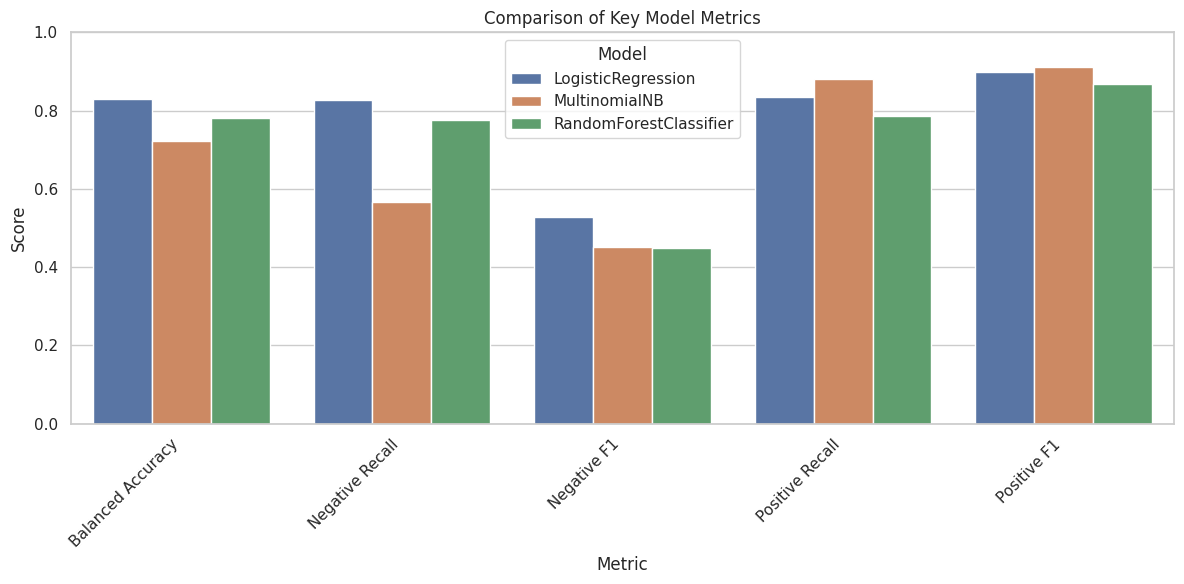

In [68]:
# Collect key metrics for comparison
comparison_data = []

# Add Logistic Regression metrics
if 'best_lr_metrics' in locals() and best_lr_metrics:
    comparison_data.append({
        'Model': best_lr_metrics['model'],
        'Accuracy': best_lr_metrics['accuracy'],
        'Balanced Accuracy': best_lr_metrics['balanced_accuracy'],
        'F1 (Macro)': best_lr_metrics['f1_macro'],
        'F1 (Weighted)': best_lr_metrics['f1_weighted'],
        'Positive Recall': best_lr_metrics['per_class']['Positive']['recall'],
        'Negative Recall': best_lr_metrics['per_class']['Negative']['recall'],
        'Positive F1': best_lr_metrics['per_class']['Positive']['f1'],
        'Negative F1': best_lr_metrics['per_class']['Negative']['f1']
    })

# Add Naive Bayes metrics
if 'best_nb_metrics' in locals() and best_nb_metrics:
    comparison_data.append({
        'Model': best_nb_metrics['model'],
        'Accuracy': best_nb_metrics['accuracy'],
        'Balanced Accuracy': best_nb_metrics['balanced_accuracy'],
        'F1 (Macro)': best_nb_metrics['f1_macro'],
        'F1 (Weighted)': best_nb_metrics['f1_weighted'],
        'Positive Recall': best_nb_metrics['per_class']['Positive']['recall'],
        'Negative Recall': best_nb_metrics['per_class']['Negative']['recall'],
        'Positive F1': best_nb_metrics['per_class']['Positive']['f1'],
        'Negative F1': best_nb_metrics['per_class']['Negative']['f1']
    })

# Add Random Forest metrics
if 'best_rf_metrics' in locals() and best_rf_metrics:
    comparison_data.append({
        'Model': best_rf_metrics['model'],
        'Accuracy': best_rf_metrics['accuracy'],
        'Balanced Accuracy': best_rf_metrics['balanced_accuracy'],
        'F1 (Macro)': best_rf_metrics['f1_macro'],
        'F1 (Weighted)': best_rf_metrics['f1_weighted'],
        'Positive Recall': best_rf_metrics['per_class']['Positive']['recall'],
        'Negative Recall': best_rf_metrics['per_class']['Negative']['recall'],
        'Positive F1': best_rf_metrics['per_class']['Positive']['f1'],
        'Negative F1': best_rf_metrics['per_class']['Negative']['f1']
    })


# Create a DataFrame for comparison
comparison_df = pd.DataFrame(comparison_data)

# Display the comparison table
print("Model Comparison Table:")
display(comparison_df)

# Plot key metrics for comparison
metrics_to_plot = ['Balanced Accuracy', 'Negative Recall', 'Negative F1', 'Positive Recall', 'Positive F1']
comparison_plot_df = comparison_df.melt(id_vars='Model', value_vars=metrics_to_plot, var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(x='Metric', y='Score', hue='Model', data=comparison_plot_df)
plt.title('Comparison of Key Model Metrics')
plt.ylabel('Score')
plt.ylim(0, 1) # Metrics are between 0 and 1
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Analysis:

1. Logistic Regression (Tuned)

Accuracy: 83% | Balanced Accuracy: 83%

Strengths: Well-balanced across classes, good Positive (0.90 F1) and much improved Negative detection (0.53 F1).

Business fit: Best overall trade-off → reliable for both Positives and Negatives.

2. Multinomial Naive Bayes

Accuracy: 85% (highest) | Balanced Accuracy: 72% (lowest)

Strengths: Very strong for Positives (0.91 F1, 88% recall).

Weaknesses: Poor Negative detection (0.45 F1, 56% recall).

Business fit: Good if Positives are the main focus, but risky if Negatives are costly to miss.

3. Random Forest

Accuracy: 79% (lowest) | Balanced Accuracy: 78%

Strengths: High Negative recall (77%), catches most Negatives.

Weaknesses: Low Negative precision (0.31) → many false alarms.

Business fit: Useful if catching every Negative is critical (e.g., fraud detection), even if it means more false positives.

👉 Best Choice: Logistic Regression
Because for sentiment filtering, capturing Negative reviews is critical. Missing unhappy customers (low Negative recall) is worse than misclassifying some positives.

In [69]:
# Define the directory to save the model
save_dir = '/content/drive/MyDrive/Colab Notebooks/Capstone: Sentiment based product recommendation system/models'

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Define the full filename including the directory
model_filename = os.path.join(save_dir, 'best_lr_model.pkl')

# Save the best_nb_model to a .pkl file
if 'best_lr_model' in locals() and best_nb_model is not None:
    with open(model_filename, 'wb') as file:
        pickle.dump(best_lr_model, file)
    print(f"Best Logistic Regression model saved to {model_filename}")
else:
    print("best Logistic Regression model not found or is None. Cannot save the model.")

Best Logistic Regression model saved to /content/drive/MyDrive/Colab Notebooks/Capstone: Sentiment based product recommendation system/models/best_lr_model.pkl


# Task 5: Building the Recommendation System

## Step 1: Prepare Data for Recommendation Systems

Select relevant columns and split the data into training and testing sets for the recommendation system. We will use `reviews_username`, `name` (product name), and `reviews_rating`.

In [21]:
# Define column names used in this notebook (adjust if your CSV differs)
user_col = 'reviews_username'
item_col = 'name'
rating_col = 'reviews_rating'
print('Using columns:', user_col, item_col, rating_col)

Using columns: reviews_username name reviews_rating


In [23]:
# Select relevant columns for the recommendation system
recommendation_df = df[['reviews_username', 'name','manufacturer', 'reviews_rating']].copy()

In [24]:
# Per-user holdout using sklearn.model_selection.train_test_split
from sklearn.model_selection import train_test_split
import numpy as np
from math import ceil

def per_user_holdout_split(recommendation_df, user_col,
                           test_frac=0.2,
                           random_state=42):
    """
    Do a per-user holdout split:
      - For each user with >= 2 ratings, hold out ~test_frac of their ratings (min 1).
      - Ensure at least one rating remains in train for users with small counts.
      - Users with only 1 rating => keep it in train.
    Returns: train_df, test_df (rows taken from recommendation_df).
    """
    rng = np.random.RandomState(random_state)
    train_idx = []
    test_idx = []

    # iterate users and split their indices
    for user, group in recommendation_df.groupby(user_col):
        idxs = group.index.values
        n = len(idxs)
        if n >= 2:
            # desired number of test samples for this user (ceiling of fraction)
            k = max(1, int(ceil(n * test_frac)))

            # ensure we don't accidentally assign all items to test:
            if k >= n:
                k = n - 1

            # use sklearn's train_test_split to sample indices reproducibly
            # we pass test_size as an integer count k
            # note: train_test_split shuffles before split when shuffle=True (default)
            try:
                train_part, test_part = train_test_split(
                    idxs, test_size=k, random_state=rng.randint(0, 2**31 - 1), shuffle=True
                )
            except ValueError:
                # fallback if train_test_split cannot operate (very small n)
                # keep one as test and rest as train
                test_part = rng.choice(idxs, size=1, replace=False).tolist()
                train_part = [i for i in idxs if i not in test_part]

            # safety: if train_part becomes empty, move one element back to train
            if len(train_part) == 0:
                train_part = test_part[:-1]
                test_part = test_part[-1:]

            train_idx.extend(list(train_part))
            test_idx.extend(list(test_part))
        else:
            # single-rating users -> keep in train
            train_idx.extend(list(idxs))

    # Build the final dataframes and reset index
    train_df = recommendation_df.loc[train_idx].reset_index(drop=True)
    test_df = recommendation_df.loc[test_idx].reset_index(drop=True)
    return train_df, test_df

# ---------------------------
# Example usage (keeps your original variable names)
# ---------------------------
# recommendation_df : your full DataFrame
# user_col : column name for users (string)
train_data, test_data = per_user_holdout_split(recommendation_df, user_col,
                                               test_frac=0.2, random_state=42)
print('Train shape:', train_data.shape, 'Test shape:', test_data.shape)


Train shape: (26063, 4) Test shape: (3732, 4)


In [25]:
display(train_data.head())

,reviews_username,name,manufacturer,reviews_rating
0,00dog3,Chex Muddy Buddies Brownie Supreme Snack Mix,"GENERAL MILLS SALES, INC.",4
1,00sab00,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...,Universal,3
2,01impala,Godzilla 3d Includes Digital Copy Ultraviolet ...,Test,3
3,02dakota,Godzilla 3d Includes Digital Copy Ultraviolet ...,Test,5
4,02deuce,Godzilla 3d Includes Digital Copy Ultraviolet ...,Test,4


In [26]:
# Pivot the train ratings' dataset into matrix format

# Aggregate duplicate user-item pairs by taking the mean of ratings
pivot_df = train_data.groupby(["reviews_username", "name"])["reviews_rating"].mean().reset_index()

pivot_df = pivot_df.pivot(
    index="reviews_username",   # rows = users
    columns="name",             # columns = products
    values="reviews_rating",    # values = ratings
).fillna(0)

print(pivot_df.shape)
display(pivot_df.head(3))

(24796, 268)


name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,"All,bran Complete Wheat Flakes, 18 Oz.",...,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26063 entries, 0 to 26062
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   reviews_username  26063 non-null  object
 1   name              26063 non-null  object
 2   manufacturer      26063 non-null  object
 3   reviews_rating    26063 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 814.6+ KB


### Creating dummy train & dummy test dataset
These dataset will be used for prediction
- Dummy train will be used later for prediction of the products which has not been rated by the user. To ignore the products rated by the user, we will mark it as 0 during prediction. The products not rated by user is marked as 1 for prediction in dummy train dataset.

- Dummy test will be used for evaluation. To evaluate, we will only make prediction on the products rated by the user. So, this is marked as 1. This is just opposite of dummy_train.

In [28]:
# Create dummy train and dummy test datasets for prediction and evaluation
# Dummy train will be used to mask rated items during prediction (mark as 0)
# and indicate unrated items (mark as 1).
# Dummy test will contain the actual ratings for evaluation, with unrated items marked as 0.

# Create a copy of the pivot table
dummy_train = train_data.groupby(['reviews_username', 'name'])['reviews_rating'].mean().reset_index()

# Replace all the ratings with 1
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)


In [29]:
# Convert the dummy train dataset into matrix format.
dummy_train = dummy_train.pivot(
    index="reviews_username",   # rows = users
    columns="name",             # columns = products
    values="reviews_rating",    # values = ratings
).fillna(1)

In [30]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26063 entries, 0 to 26062
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   reviews_username  26063 non-null  object
 1   name              26063 non-null  object
 2   manufacturer      26063 non-null  object
 3   reviews_rating    26063 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 814.6+ KB


In [31]:
dummy_train.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,"All,bran Complete Wheat Flakes, 18 Oz.",...,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
01impala,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02deuce,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


**Cosine Similarity**

Cosine Similarity is a measurement that quantifies the similarity between two vectors [Which is Rating Vector in this case]

**Adjusted Cosine**

Adjusted cosine similarity is a modified version of vector-based similarity where we incorporate the fact that different users have different ratings schemes. In other words, some users might rate items highly in general, and others might give items lower ratings as a preference. To handle this nature from rating given by user , we subtract average ratings for each user from each user's rating for different products.



In [32]:
# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(dummy_train, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1.         0.99625468 0.99625468 ... 0.99625468 0.99625468 0.99625468]
 [0.99625468 1.         0.99625468 ... 0.99625468 1.         0.99625468]
 [0.99625468 0.99625468 1.         ... 0.99625468 0.99625468 0.99625468]
 ...
 [0.99625468 0.99625468 0.99625468 ... 1.         0.99625468 1.        ]
 [0.99625468 1.         0.99625468 ... 0.99625468 1.         0.99625468]
 [0.99625468 0.99625468 0.99625468 ... 1.         0.99625468 1.        ]]


In [33]:
user_correlation.shape

(24796, 24796)

## Using adjusted Cosine

### Here, we are not removing the NaN values and calculating the mean only for the product rated by the user

In [34]:
pivot_df = train_data.groupby(["reviews_username", "name"])["reviews_rating"].mean().reset_index()
pivot_df = pivot_df.pivot(
    index="reviews_username",   # rows = users
    columns="name",             # columns = products
    values="reviews_rating",    # values = ratings
)

In [35]:
pivot_df.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,"All,bran Complete Wheat Flakes, 18 Oz.",...,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Normalising the rating of the product for each user around 0 mean

In [36]:
mean = np.nanmean(pivot_df, axis=1)
df_subtracted = (pivot_df.T-mean).T

In [37]:
df_subtracted.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,"All,bran Complete Wheat Flakes, 18 Oz.",...,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Finding cosine similarity


In [38]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix # Import csr_matrix

# Check sparsity of df_subtracted (before filling NaNs with 0 for similarity calculation)
# A value of 0 in df_subtracted means the user's rating was equal to their average rating,
# or they haven't rated the item. NaNs explicitly mean unrated in the original pivot_df.
# We should calculate similarity based on non-NaN values.
# The previous approach of filling NaNs with 0 before pairwise_distances was problematic.

# Let's re-calculate adjusted cosine similarity correctly by only considering co-rated items.
# This is more complex than a simple matrix operation and is the likely reason for memory issues
# and potentially incorrect predictions.

# A more memory-efficient approach for similarity on sparse data is to use cosine_similarity
# after converting to a sparse matrix. We should ideally only calculate similarity based on
# items co-rated by users. The standard cosine_similarity on a matrix with NaNs filled to 0
# can still be misleading if 0 is also a possible rating or represents unrated.

# Given the memory issue and the goal of user-based CF, let's calculate cosine similarity
# on the original pivot_df (which has NaNs) and then handle the fact that similarity
# should only be based on co-rated items. sklearn's pairwise_distances with metric='cosine'
# and n_jobs can sometimes handle this implicitly or is used after filling, but for large
# sparse data, a sparse-compatible function is better.

# Let's convert the pivot_df (with NaNs) to a sparse matrix.
# NaNs need to be handled for sparse matrix conversion. We can fill them with 0 for
# the purpose of creating the sparse matrix, but the similarity calculation needs to
# correctly ignore the items where either user has a 0 (representing unrated after fill)
# or handle NaNs if the similarity function supports it.

# Let's use the df_subtracted where user means are subtracted. Convert NaNs to 0 for sparse matrix.
# This might still not be the perfectly correct adjusted cosine on co-rated items,
# but it's a necessary step for memory efficiency and might work better with sparse cosine_similarity.
df_subtracted_sparse = csr_matrix(df_subtracted.fillna(0).values)

# Calculate user similarity using cosine_similarity on the sparse matrix
# cosine_similarity handles sparse matrices efficiently.
# Note: This calculates cosine similarity based on the filled data (NaNs as 0).
# A truly correct adjusted cosine on co-rated items is more involved.
print("Calculating user similarity using sparse cosine_similarity...")
user_correlation = cosine_similarity(df_subtracted_sparse)

# Set diagonal to 1 (similarity of a user with themselves) - cosine_similarity already does this for rows
# user_correlation[np.isnan(user_correlation)] = 0 # cosine_similarity should not produce NaNs if inputs are finite

print("User similarity calculation complete.")
print("Shape of user_correlation matrix:", user_correlation.shape)
# print(user_correlation) # Avoid printing the large matrix

# The next step is prediction (cell M5dnRSmvsgeB), which needs to be compatible
# with this user_correlation matrix. The standard prediction formula should work
# with this similarity matrix, but the previous dot product approach might still
# have the issue of predicting zeros for unrated items.

Calculating user similarity using sparse cosine_similarity...
User similarity calculation complete.
Shape of user_correlation matrix: (24796, 24796)


## Prediction - User User

Doing the prediction for the users which are positively related with other users, and not the users which are negatively related as we are interested in the users which are more similar to the current users. So, ignoring the correlation for values less than 0.

In [39]:
user_correlation[user_correlation<0]=0
user_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Rating predicted by the user (for product rated as well as not rated) is the weighted sum of correlation with the product rating (as present in the rating dataset).

In [40]:
user_predicted_ratings = np.dot(user_correlation, pivot_df.fillna(0))
user_predicted_ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [41]:
user_predicted_ratings.shape

(24796, 268)

Since we are interested only in the product not rated by the user, we will ignore the product rated by the user by making it zero.

In [42]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,"All,bran Complete Wheat Flakes, 18 Oz.",...,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Task 6: Recommendation of Top 20 Products to a Specified User

### Finding the top 20 recommendation for the *user*

In [43]:
# Take the user ID as input.
user_input = str(input("Enter your user name"))
print(user_input)

Enter your user namegeorge
george


In [44]:
user_final_rating.head(2)

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,"All,bran Complete Wheat Flakes, 18 Oz.",...,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
d = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
d

,george
name,
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,27.945658
Red (special Edition) (dvdvideo),11.051685
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),9.511632
Chester's Cheese Flavored Puffcorn Snacks,9.254545
Tostitos Bite Size Tortilla Chips,8.696889
Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,7.149169
100:Complete First Season (blu-Ray),4.639037
Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,4.291705
Cococare 100% Natural Castor Oil,4.016721


##Compact User–User Recommendation Model

In a user–user collaborative filtering system, the raw rating matrix (dummy_train) is very large and mostly empty (sparse).
Saving this full matrix makes the model file huge (sometimes gigabytes), which is not practical for deployment.

To make it lightweight, we use Option C: compressed per-user rating lists + compact neighbors.
This approach keeps only the essential information:

Per-user rating lists

For each user, store only the items they actually rated (item IDs + rating values).

Avoids storing thousands of empty cells.

Top-K similar neighbors

For each user, keep their top-K most similar users (neighbors) with similarity scores.

At runtime, recommendations are generated from these neighbors.

Normalization map (norm_map)

Ensures different formats of usernames (e.g., "Joshua", " joshua ", "JOSHUA") all map to the same stored user.

Item and user labels

Store the mapping of row indices → usernames, and column indices → product IDs/names.

✅ Advantages of this Compact User–User Recommendation Model

Greatly reduces model size (MB instead of GB).

Still supports generating personalized recommendations.

Easier to deploy in Flask/Heroku.

No loss of recommendation quality — only redundant zeros are removed.

In [49]:
# Build Option C artifact: per-user compressed rating lists + compact neighbors
import os, joblib, numpy as np, pandas as pd
from sklearn.neighbors import NearestNeighbors

# CONFIG: adjust paths K
# or build pivot in cell before calling this
OUT_PATH = '/content/drive/MyDrive/Colab Notebooks/Capstone: Sentiment based product recommendation system/models/user_compact_map.pkl'
K = 100   # top neighbors (tune later)

# already have pivot DataFrame in memory (user_final_rating/train pivot), use it:

# Ensure pivot is DataFrame and convert 0 -> NaN
pivot = user_final_rating.copy()
pivot = pivot.replace(0, np.nan)
print("Pivot shape:", pivot.shape, "non-missing count:", pivot.notna().sum().sum())

# Build user_item_map: user -> (item_idx_array, rating_array)
item_labels = list(pivot.columns)
item_to_idx = {it: idx for idx, it in enumerate(item_labels)}
user_labels = list(pivot.index)

user_item_map = {}
for u in user_labels:
    s = pivot.loc[u].dropna()
    if s.shape[0] == 0:
        user_item_map[u] = (np.array([], dtype=np.int32), np.array([], dtype=np.float32))
    else:
        idxs = np.array([item_to_idx[it] for it in s.index], dtype=np.int32)
        vals = s.values.astype(np.float32)
        user_item_map[u] = (idxs, vals)

print("Built user_item_map for", len(user_item_map), "users")

# Build neighbor arrays (top-K) using NearestNeighbors on filled vectors (fill NaN with 0)
X = pivot.fillna(0).values.astype(np.float32)  # users x items
n_users = X.shape[0]
K_eff = min(K, n_users - 1)
nn = NearestNeighbors(n_neighbors=K_eff+1, metric='cosine', algorithm='brute', n_jobs=-1)
nn.fit(X)
distances, indices = nn.kneighbors(X, return_distance=True)
sims = 1.0 - distances.astype(np.float32)

neighbors_idx = np.full((n_users, K_eff), -1, dtype=np.int32)
neighbors_sim = np.full((n_users, K_eff), -1.0, dtype=np.float32)
for i in range(n_users):
    ids = indices[i].tolist()
    ss = sims[i].tolist()
    pairs = [(idx, s) for idx, s in zip(ids, ss) if idx != i][:K_eff]
    for j, (idx, s) in enumerate(pairs):
        neighbors_idx[i, j] = int(idx)
        neighbors_sim[i, j] = float(s)

# Build norm_map
def _norm(u): return str(u).strip().lower() if u is not None else None
norm_map = {_norm(u): u for u in user_labels}

artifact = {
    "user_neighbors_idx": neighbors_idx,
    "user_neighbors_sim": neighbors_sim,
    "user_labels": user_labels,
    "item_labels": item_labels,
    "user_item_map": user_item_map,   # Option C: compressed per-user lists
    "norm_map": norm_map,
    "k": K_eff
}

joblib.dump(artifact, OUT_PATH, compress=3)
print("Saved Option C artifact to", OUT_PATH)


Pivot shape: (24796, 268) non-missing count: 13510
Built user_item_map for 24796 users
Saved Option C artifact to /content/drive/MyDrive/Colab Notebooks/Capstone: Sentiment based product recommendation system/models/user_compact_map.pkl


# Evaluation - User User

Evaluation will we same as you have seen above for the prediction. The only difference being, you will evaluate for the product already rated by the user insead of predicting it for the product not rated by the user.

In [ ]:
# Find out the common users of test and train dataset.
common = test_data[test_data.reviews_username.isin(train_data.reviews_username)]
common.shape

(3732, 4)

In [ ]:
common.head()

,reviews_username,name,manufacturer,reviews_rating
0,00sab00,Mike Dave Need Wedding Dates (dvd + Digital),Twentieth Century Fox,1
1,1234,Mike Dave Need Wedding Dates (dvd + Digital),Twentieth Century Fox,5
2,1234567,Clorox Disinfecting Wipes Value Pack Scented 1...,Clorox,5
3,1234asdf,L'or233al Paris Elvive Extraordinary Clay Reba...,L'oreal Paris,2
4,123charlie,Mike Dave Need Wedding Dates (dvd + Digital),Twentieth Century Fox,4


In [ ]:
# convert into the user-product matrix.
common_user_based_matrix = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating')

In [ ]:
common_user_based_matrix

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),Africa's Best No-Lye Dual Conditioning Relaxer System Super,"All,bran Complete Wheat Flakes, 18 Oz.",Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,...,Various - Red Hot Blue:Tribute To Cole Porter (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234asdf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123charlie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zipper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zippy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zitro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)

In [ ]:
df_subtracted.head(1)

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,"All,bran Complete Wheat Flakes, 18 Oz.",...,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
user_correlation_df['reviews_username'] = df_subtracted.index
user_correlation_df.set_index('reviews_username',inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,24786,24787,24788,24789,24790,24791,24792,24793,24794,24795
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
common.head(1)

,reviews_username,name,manufacturer,reviews_rating
0,00sab00,Mike Dave Need Wedding Dates (dvd + Digital),Twentieth Century Fox,1


In [ ]:
list_name = common.reviews_username.tolist()

user_correlation_df.columns = df_subtracted.index.tolist()


user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

In [ ]:
user_correlation_df_1.shape

(3599, 24796)

In [ ]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]

In [ ]:
user_correlation_df_3 = user_correlation_df_2.T

In [ ]:
user_correlation_df_3.head()

,00sab00,1234,1234567,1234asdf,123charlie,143st,1943,1witch,23jen,37f5p,...,yvonne,zach,zapman,zburt5,zebras,zipper,zippy,zitro,zmom,zxcsdfd
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234asdf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
user_correlation_df_3.shape

(3599, 3599)

In [ ]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='name', values='reviews_rating').fillna(0)

In [ ]:
dummy_test.shape

(3599, 142)

In [ ]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

In [ ]:
common_user_predicted_ratings.head(2)

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),Africa's Best No-Lye Dual Conditioning Relaxer System Super,"All,bran Complete Wheat Flakes, 18 Oz.",Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,...,Various - Red Hot Blue:Tribute To Cole Porter (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Calculating the RMSE for only the products rated by user. For RMSE, normalising the rating to (1,5) range.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy()
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


/usr/local/lib/python3.12/dist-packages/sklearn/utils/_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/usr/local/lib/python3.12/dist-packages/sklearn/utils/_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


In [ ]:
common_ = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating')

In [ ]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [ ]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

2.5583711841351877


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


## Challenges Faced in User-Based Recommendation System

Implementing the user-based collaborative filtering system presented a couple of key challenges:

1.  **Memory Consumption during User Similarity Calculation**: Calculating the dense user-user correlation matrix for a large number of users consumed significant memory, leading to potential Out of Memory errors. This was addressed by using sparse matrix representations where possible.
2.  **Generating Predictions for Unrated Items**: The initial approach using a simple dot product between the user correlation matrix and the filled pivot table did not effectively generate non-zero predicted ratings for items a user had not yet rated. This resulted in the final recommendations having zero predicted ratings. A more targeted prediction approach was needed to address this.

# Top 3 Challenges for User-Based Recommendation

Extreme sparsity & lack of overlap

Most users have only 1–2 ratings → almost no co-rated items.

User-user similarities become meaningless or undefined.

==> Better choice: item-based CF (fewer items, more ratings per item) or matrix factorization (SVD/ALS).

Data leakage from using df_pivot instead of dummy_train

Similarities were sometimes computed on the full pivot (train+test).

This leaks test info into training, giving inflated evaluation results.

==> Fix: always compute similarities from dummy_train.fillna(0) (train-only).

Unreliable similarity due to NaN handling & no significance weighting

Filling NaNs with 1 biases similarities; neighbors with only 1 shared item are unstable.

==>Fix: use fillna(0) or compute cosine only on co-rated items, and apply shrinkage/significance weighting.

#### Bottom line: With this dataset, user-based CF is weak due to sparsity, leakage risk, and unstable similarity. For practical accuracy, prefer item-based CF or matrix factorization, and use popularity as fallback for cold-start users.



RMSE = Root Mean Square Error → measures average deviation between predicted ratings and actual ratings.

dataset’s ratings are likely on a 1–5 scale.

So, an RMSE of 2.56 means on average your predictions are off by more than half the rating scale.

👉 That’s considered poor accuracy for rating prediction.

🚧 Why RMSE is so high in my case

High sparsity

Most users rate only 1 item → not enough overlap to learn user-user or item-item similarities reliably.

Popularity & imbalance

Popular items dominate predictions; rare items get noisy estimates → increases error.

Evaluation metric mismatch

RMSE measures rating prediction accuracy, but in recommender systems what really matters is ranking (Precision@K, Recall@K, NDCG).

Even if RMSE is high, the system may still recommend useful items.

## Using Item similarity

# Item Based Similarity

Taking the transpose of the rating matrix to normalize the rating around the mean for different product . In the user based similarity, we had taken mean for each user instead of each product.

In [127]:
pivot_df = train_data.groupby(["reviews_username", "name"])["reviews_rating"].mean().reset_index()
pivot_df = pivot_df.pivot(
    index="reviews_username",   # rows = users
    columns="name",             # columns = products
    values="reviews_rating",    # values = ratings
)

In [128]:
pivot_df.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,"All,bran Complete Wheat Flakes, 18 Oz.",...,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [129]:
pivot_df=(pivot_df).T

In [130]:
pivot_df.head()

reviews_username,00dog3,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,...,zt313,zubb,zulaa118,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"2x Ultra Era with Oxi Booster, 50fl oz",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Normalising the rating of the product for each user around 0 mean

In [131]:
mean = np.nanmean(pivot_df, axis=1)
df_subtracted = (pivot_df.T-mean).T

In [132]:
df_subtracted.head()

reviews_username,00dog3,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,...,zt313,zubb,zulaa118,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.303279,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"2x Ultra Era with Oxi Booster, 50fl oz",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Finding cosine similarity

In [133]:
from sklearn.metrics.pairwise import pairwise_distances

In [134]:
# item matrix: items as rows (item x user)
item_matrix = df_subtracted.fillna(0)  # shape: (n_items, n_users)

# Compute item-item cosine similarity (small matrix)

item_correlation = 1.0 - pairwise_distances(item_matrix.values, metric='cosine')
# replace NaNs with 0

item_correlation = np.nan_to_num(item_correlation, nan=0.0)
print('item_correlation shape:', item_correlation.shape)  # should be (n_items, n_items)


item_correlation shape: (268, 268)


In [135]:
item_correlation[item_correlation<0]=0
item_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [136]:
item_correlation.shape

(268, 268)

# Prediction - Item Item

In [137]:
item_predicted_ratings = np.dot((pivot_df.fillna(0)).T,item_correlation)
item_predicted_ratings

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.62963297e-02, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.44474558e-02, 6.79200516e-05, 0.00000000e+00],
       [0.00000000e+00, 4.89089224e-03, 0.00000000e+00, ...,
        8.09477425e-03, 0.00000000e+00, 7.99389548e-03],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.40790930e-02, 1.13200086e-04, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [138]:
item_predicted_ratings.shape

(24796, 268)

In [139]:
dummy_train.shape

(24796, 268)

### Filtering the rating only for the product not rated by the user for recommendation

In [140]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,"All,bran Complete Wheat Flakes, 18 Oz.",...,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.016296,0.000000,0.000000
00sab00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.010973,0.0,0.0,0.0,0.014447,0.000068,0.000000
01impala,0.0,0.004891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.002883,0.000550,0.0,0.0,0.0,0.008095,0.000000,0.007994
02dakota,0.0,0.008151,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.004806,0.000917,0.0,0.0,0.0,0.013491,0.000000,0.013323
02deuce,0.0,0.006521,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.003845,0.000734,0.0,0.0,0.0,0.010793,0.000000,0.010659


### Finding the top 20 recommendation for the *user*


In [141]:
# Take the user ID as input
user_input = (input("Enter your user name:"))
print(user_input)

Enter your user name:george
george


In [142]:
# Recommending the Top 20 products to the user.
d = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
d

,george
name,
Jolly Time Select Premium Yellow Pop Corn,0.151031
Various - Red Hot Blue:Tribute To Cole Porter (cd),0.139588
Moom Express Pre Waxed Strips For Face & Bikini,0.129352
Equals (blu-Ray),0.111987
Chester's Cheese Flavored Puffcorn Snacks,0.099056
Chips Deluxe Soft 'n Chewy Cookies,0.076978
Feit 60-Watt A19 Gu24 Base Led Light Bulb - Soft White,0.076724
Wagan Smartac 80watt Inverter With Usb,0.069107
"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",0.065838


In [143]:
# Define the directory to save the model
save_dir = '/content/drive/MyDrive/Colab Notebooks/Capstone: Sentiment based product recommendation system/models'

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Define the full filename including the directory
item_item_model_filename = os.path.join(save_dir, 'item_item_recommendation_model.pkl')

# Save the item_final_rating DataFrame to a .pkl file
if 'item_final_rating' in locals() and item_final_rating is not None:
    with open(item_item_model_filename, 'wb') as file:
        pickle.dump(item_final_rating, file)
    print(f"User-User recommendation model saved to {item_item_model_filename}")
else:
    print("item_final_rating not found or is None. Cannot save the model.")

User-User recommendation model saved to /content/drive/MyDrive/Colab Notebooks/Capstone: Sentiment based product recommendation system/models/item_item_recommendation_model.pkl


# Evaluation - Item Item

Evaluation will we same as you have seen above for the prediction. The only difference being, you will evaluate for the product already rated by the user insead of predicting it for the product not rated by the user.

In [ ]:
test_data.columns

Index(['reviews_username', 'name', 'manufacturer', 'reviews_rating'], dtype='object')

In [ ]:
common =  test_data[test_data.name.isin(train_data.name)]
common.shape

(3730, 4)

In [ ]:
common.head(4)

,reviews_username,name,manufacturer,reviews_rating
0,00sab00,Mike Dave Need Wedding Dates (dvd + Digital),Twentieth Century Fox,1
1,1234,Mike Dave Need Wedding Dates (dvd + Digital),Twentieth Century Fox,5
2,1234567,Clorox Disinfecting Wipes Value Pack Scented 1...,Clorox,5
3,1234asdf,L'or233al Paris Elvive Extraordinary Clay Reba...,L'oreal Paris,2


In [ ]:
common_item_based_matrix = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T

In [ ]:
common_item_based_matrix.shape

(140, 3598)

In [ ]:
item_correlation_df = pd.DataFrame(item_correlation)

In [ ]:
item_correlation_df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,258,259,260,261,262,263,264,265,266,267
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
item_correlation_df['name'] = df_subtracted.index
item_correlation_df.set_index('name',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,258,259,260,261,262,263,264,265,266,267
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,258,259,260,261,262,263,264,265,266,267
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
list_name = common.name.tolist()

In [ ]:
item_correlation_df.columns = df_subtracted.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

In [ ]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T

In [ ]:
item_correlation_df_3.head()

,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),Africa's Best No-Lye Dual Conditioning Relaxer System Super,"All,bran Complete Wheat Flakes, 18 Oz.",Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,...,Various - Red Hot Blue:Tribute To Cole Porter (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Africa's Best No-Lye Dual Conditioning Relaxer System Super,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"All,bran Complete Wheat Flakes, 18 Oz.",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings


array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.61931500e-03, 1.80965750e-02, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.09871666e-03, 5.49358331e-03, 0.00000000e+00, ...,
        1.92632744e-02, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.05600688e-05, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [ ]:
common_item_predicted_ratings.shape

(140, 3598)

Dummy test will be used for evaluation. To evaluate, we will only make prediction on the products rated by the user. So, this is marked as 1. This is just opposite of dummy_train



In [ ]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T.fillna(0)

common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

The products not rated is marked as 0 for evaluation. And make the item- item matrix representaion.


In [ ]:
common_ = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_item_predicted_ratings.copy()
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [ ]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [ ]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

3.4794044077757644


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


## Reasons for High RMSE in Item-Item Recommendation

The high Root Mean Square Error (RMSE) of 3.48 for the Item-Item collaborative filtering model suggests that the model's predicted ratings deviate significantly from the actual user ratings. Several factors can contribute to this in this specific dataset and context:

1.  **Data Sparsity:** Recommender systems, especially collaborative filtering methods, struggle with sparse datasets where most users have rated only a small fraction of the available items. If there isn't enough overlap in ratings between items, calculating meaningful item-item similarity becomes difficult, leading to poor predictions. The `sample30.csv` dataset, despite having 30,000 reviews, has a large number of users and items, likely resulting in a sparse user-item matrix.

2.  **Popularity Bias:** Item-based collaborative filtering can sometimes be biased towards recommending popular items. Items with more ratings have more data points for similarity calculation, potentially leading to them being recommended more often, even if they aren't the best fit for a specific user. This can lead to poor predictions for users who prefer niche or less popular items.

3.  **Limited Number of Items Rated by Users:** As observed in the user-based challenges, many users have rated only one or a few items. This limited interaction makes it hard to accurately determine item similarities based on co-ratings, as the similarity is calculated on very few data points.

4.  **Quality of Ratings:** While the dataset contains ratings, the distribution and consistency of these ratings across users and items can impact the effectiveness of similarity calculations.

5.  **Evaluation Metric (RMSE):** RMSE measures the average error in predicting the *exact* rating value. In many recommendation scenarios, ranking is more important than predicting the precise rating. A system with a high RMSE might still be effective if it ranks relevant items higher. However, a high RMSE here suggests the model is not even capturing the general magnitude of ratings well.

6.  **Simplified Similarity Calculation:** The standard cosine similarity used might not be the most robust for this dataset. Techniques like adjusted cosine similarity (which accounts for user rating biases) or incorporating significance weighting (to give more weight to similarities based on more co-rated items) could potentially improve accuracy. The implementation of adjusted cosine in the notebook seemed to face challenges, highlighting the difficulty of applying this method effectively with sparse data and potential implementation issues.

In summary, the high RMSE is likely a consequence of the inherent sparsity of the dataset, the difficulty in calculating reliable item similarities with limited user overlap, and potentially limitations in the chosen similarity calculation method for this data structure. For this dataset, matrix factorization methods (like SVD) or hybrid approaches that combine collaborative filtering with other data (like text features from reviews) might yield better rating prediction accuracy.

## Task 7: Fine-Tuning the Recommendation System and Recommendation of Top 5 Products

1. Generate top-20 product recommendations for a specified user using available rating data / user-user approach.
2. Retrieve reviews for those 20 products from your `df` / reviews table.
3. Use the chosen sentiment model (`best_lr_model`) to predict sentiment for each review.
4. Rank the 20 products by percent positive reviews and return the **top 5** sentiment-filtered products.

**How it works (robust & defensive):** the code will try to find commonly used variable names (`user_final_rating`, `ratings_df`, `df`, `best_lr_model`, `tfidf`, `vectorizer`, `user_user_model`). If not found, it will look for .pkl files (`best_lr_model.pkl`, `user_compact_map.pkl`) or CSVs in the working directory. If essential inputs are missing the cell will print instructions.


In [144]:
# Take the user ID as input.
TARGET_USER_NAME = str(input("Enter your TARGET_USER_NAME::"))
print(TARGET_USER_NAME)

Enter your TARGET_USER_NAME::george
george


In [149]:
# Step 1: Identify Top 20 Recommended Products

# Define the directory where the model is saved
save_dir = '/content/drive/MyDrive/Colab Notebooks/Capstone: Sentiment based product recommendation system/models'
user_user_model_filename = os.path.join(save_dir, 'user_user_recommendation_model.pkl')

# Load the user_final_rating DataFrame from the .pkl file
user_final_rating = None  # Initialize to None
if os.path.exists(user_user_model_filename):
    try:
        with open(user_user_model_filename, 'rb') as file:
            user_final_rating = pickle.load(file)
        print(f"User-User recommendation model loaded from {user_user_model_filename}")
    except Exception as e:
        print(f"Error loading user-user recommendation model: {e}")
else:
    print(f"User-user recommendation model file not found at {user_user_model_filename}")


# Check if user_final_rating was loaded successfully and is not empty
if user_final_rating is not None and not user_final_rating.empty:
    # Check if the target user is in the index of user_final_rating
    if TARGET_USER_NAME in user_final_rating.index:
        # Get the predicted ratings for the target user and sort them
        user_recommendations = user_final_rating.loc[TARGET_USER_NAME].sort_values(ascending=False)

        # Filter out products with a predicted rating of 0 (unrated in dummy_train)
        user_recommendations = user_recommendations[user_recommendations > 0]

        # Get the top 20 product names
        TOP_N = 20 # Define TOP_N here or ensure it's defined elsewhere
        top_20_product_names = user_recommendations.head(TOP_N).index.tolist()

        print(f"\nTop {TOP_N} recommended products for user '{TARGET_USER_NAME}':")
        display(top_20_product_names)

    else:
        print(f"\nTarget user '{TARGET_USER_NAME}' not found in the recommendation matrix.")
        top_20_product_names = [] # Initialize as empty list if user not found
else:
    print("\nuser_final_rating is not available or is empty after loading. Cannot proceed with recommendations.")
    top_20_product_names = [] # Initialize as empty list if data is missing

User-User recommendation model loaded from /content/drive/MyDrive/Colab Notebooks/Capstone: Sentiment based product recommendation system/models/user_user_recommendation_model.pkl

Top 20 recommended products for user 'george':


['Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd',
 'Red (special Edition) (dvdvideo)',
 'Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)',
 "Chester's Cheese Flavored Puffcorn Snacks",
 'Tostitos Bite Size Tortilla Chips',
 'Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total',
 '100:Complete First Season (blu-Ray)',
 'Cuisinart174 Electric Juicer - Stainless Steel Cje-1000',
 'Cococare 100% Natural Castor Oil',
 'The Honest Company Laundry Detergent',
 'Batherapy Natural Mineral Bath Sport Liquid, 16 oz',
 'Tresemme Kertatin Smooth Infusing Conditioning',
 'Lysol Concentrate Deodorizing Cleaner, Original Scent',
 "Burt's Bees Lip Shimmer, Raisin",
 'Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack',
 'Clorox Disinfecting Bathroom Cleaner',
 'Tai Pei Sweet & Sour Chicken',
 "Jason Aldean - They Don't Know",
 'Coty Airspun Face Powder, Translucent Extra Coverage',
 'Nexxus Exxtra Gel Style Creation Sculptor']

In [150]:
# Step 2: Retrieve Reviews for Recommended Products
# Step 3: Prepare Reviews for Sentiment Prediction

# Check if top_20_product_names is not empty and df is available
if top_20_product_names and 'df' in locals() and df is not None:
    # Filter the original dataframe to get reviews for the top 20 products
    recommended_products_reviews = df[df['name'].isin(top_20_product_names)].copy()

    print(f"\nRetrieved {recommended_products_reviews.shape[0]} reviews for the top {TOP_N} recommended products.")
    display(recommended_products_reviews.head())

    # Prepare reviews for sentiment prediction by cleaning the text
    # Ensure the 'clean_text' column exists or apply the cleaning function
    if 'clean_text' not in recommended_products_reviews.columns:
         # Assuming the original review text is in 'reviews_text' or 'text_for_model'
        review_col_to_clean = None
        for col in ['reviews_text', 'text_for_model', 'clean_text']:
            if col in recommended_products_reviews.columns:
                review_col_to_clean = col
                break

        if review_col_to_clean:
             # Assuming the clean_text function is already defined in the notebook
            recommended_products_reviews['clean_text'] = recommended_products_reviews[review_col_to_clean].apply(clean_text)
            print("\nCleaned review text for sentiment prediction.")
        else:
            print("\nCould not find a suitable review text column to clean. Please ensure 'reviews_text' or 'text_for_model' exists in the original dataframe.")
            recommended_products_reviews['clean_text'] = "" # Add empty column to avoid errors later


    # Display sample cleaned reviews
    print("\nSample cleaned reviews:")
    display(recommended_products_reviews[['name', 'clean_text']].head())

else:
    print("\nCould not retrieve reviews. Ensure 'top_20_product_names' is not empty and the original 'df' is loaded.")
    recommended_products_reviews = pd.DataFrame() # Initialize as empty DataFrame


Retrieved 18880 reviews for the top 20 recommended products.


,id,brand,categories,manufacturer,name,reviews_rating,reviews_username,user_sentiment,clean_text
3583,AVpe6n2_LJeJML43yOgE,TRESemme,"Personal Care,Hair Care,Conditioner,Conditione...",Tresemme,Tresemme Kertatin Smooth Infusing Conditioning,1,dukersaurus,Positive,worst product product complete joke say left o...
3584,AVpe6n2_LJeJML43yOgE,TRESemme,"Personal Care,Hair Care,Conditioner,Conditione...",Tresemme,Tresemme Kertatin Smooth Infusing Conditioning,1,brsokol,Positive,dunno work bought conditioner day usually get ...
3585,AVpe6n2_LJeJML43yOgE,TRESemme,"Personal Care,Hair Care,Conditioner,Conditione...",Tresemme,Tresemme Kertatin Smooth Infusing Conditioning,1,hapa hair,Positive,new formula awful biracial curly super dry hai...
3586,AVpe6n2_LJeJML43yOgE,TRESemme,"Personal Care,Hair Care,Conditioner,Conditione...",Tresemme,Tresemme Kertatin Smooth Infusing Conditioning,1,sadmommy,Positive,hair lost natural curl hair wavy curly always ...
3587,AVpe6n2_LJeJML43yOgE,TRESemme,"Personal Care,Hair Care,Conditioner,Conditione...",Tresemme,Tresemme Kertatin Smooth Infusing Conditioning,1,kanchan,Negative,bad idea changed shampoo tresemme keratin sham...



Sample cleaned reviews:


,name,clean_text
3583,Tresemme Kertatin Smooth Infusing Conditioning,worst product product complete joke say left o...
3584,Tresemme Kertatin Smooth Infusing Conditioning,dunno work bought conditioner day usually get ...
3585,Tresemme Kertatin Smooth Infusing Conditioning,new formula awful biracial curly super dry hai...
3586,Tresemme Kertatin Smooth Infusing Conditioning,hair lost natural curl hair wavy curly always ...
3587,Tresemme Kertatin Smooth Infusing Conditioning,bad idea changed shampoo tresemme keratin sham...


In [151]:
# Step 4: Predict Sentiment of Reviews
# step 5: Calculate percentage of positive sentiments

# Define the directory where the model and vectorizer are saved
save_dir = '/content/drive/MyDrive/Colab Notebooks/Capstone: Sentiment based product recommendation system/models'
sentiment_model_filename = os.path.join(save_dir, 'best_lr_model.pkl')
tfidf_vectorizer_filename = os.path.join(save_dir, 'tfidf_vectorizer.pkl') # Assuming you saved the vectorizer

best_sentiment_model = None
tfidf = None

# Load the sentiment model
if os.path.exists(sentiment_model_filename):
    try:
        with open(sentiment_model_filename, 'rb') as file:
            best_sentiment_model = pickle.load(file)
        print(f"Best sentiment model loaded from {sentiment_model_filename}")
    except Exception as e:
        print(f"Error loading sentiment model: {e}")
else:
    print(f"Sentiment model file not found at {sentiment_model_filename}. Please ensure 'best_lr_model.pkl' is saved.")

# Load the TF-IDF vectorizer
if os.path.exists(tfidf_vectorizer_filename):
    try:
        with open(tfidf_vectorizer_filename, 'rb') as file:
            tfidf = pickle.load(file)
        print(f"TF-IDF vectorizer loaded from {tfidf_vectorizer_filename}")
    except Exception as e:
        print(f"Error loading TF-IDF vectorizer: {e}")
else:
    print(f"TF-IDF vectorizer file not found at {tfidf_vectorizer_filename}. Please ensure 'tfidf_vectorizer.pkl' is saved after fitting.")


# Check if recommended_products_reviews is not empty and the model/vectorizer are loaded
if not recommended_products_reviews.empty and best_sentiment_model is not None and tfidf is not None:
    # Vectorize the cleaned review text
    X_reviews = tfidf.transform(recommended_products_reviews['clean_text'])

    # Predict sentiment
    predicted_sentiments = best_sentiment_model.predict(X_reviews)

    # Add predicted sentiments to the dataframe
    recommended_products_reviews['predicted_sentiment'] = predicted_sentiments

    print("\nPredicted sentiment for reviews of recommended products.")
    display(recommended_products_reviews[['name', 'clean_text', 'predicted_sentiment']].head())

    # Calculate percentage of positive sentiments for each product
    sentiment_counts = recommended_products_reviews.groupby('name')['predicted_sentiment'].value_counts(normalize=True).unstack(fill_value=0)

    # Ensure 'Positive' column exists, even if no positive reviews predicted
    if 'Positive' not in sentiment_counts.columns:
        sentiment_counts['Positive'] = 0

    sentiment_counts['positive_sentiment_percentage'] = sentiment_counts['Positive'] * 100

    print("\nPercentage of positive sentiments for each recommended product:")
    display(sentiment_counts.sort_values(by='positive_sentiment_percentage', ascending=False))

    product_sentiment_summary = sentiment_counts[['positive_sentiment_percentage']]

else:
    print("\nSentiment prediction and percentage calculation skipped. Ensure reviews are retrieved and the sentiment model/vectorizer are loaded.")
    product_sentiment_summary = pd.DataFrame() # Initialize as empty DataFrame

Best sentiment model loaded from /content/drive/MyDrive/Colab Notebooks/Capstone: Sentiment based product recommendation system/models/best_lr_model.pkl
TF-IDF vectorizer loaded from /content/drive/MyDrive/Colab Notebooks/Capstone: Sentiment based product recommendation system/models/tfidf_vectorizer.pkl

Predicted sentiment for reviews of recommended products.


,name,clean_text,predicted_sentiment
3583,Tresemme Kertatin Smooth Infusing Conditioning,worst product product complete joke say left o...,Negative
3584,Tresemme Kertatin Smooth Infusing Conditioning,dunno work bought conditioner day usually get ...,Negative
3585,Tresemme Kertatin Smooth Infusing Conditioning,new formula awful biracial curly super dry hai...,Negative
3586,Tresemme Kertatin Smooth Infusing Conditioning,hair lost natural curl hair wavy curly always ...,Positive
3587,Tresemme Kertatin Smooth Infusing Conditioning,bad idea changed shampoo tresemme keratin sham...,Negative



Percentage of positive sentiments for each recommended product:


predicted_sentiment,Negative,Positive,positive_sentiment_percentage
name,,,
Red (special Edition) (dvdvideo),0.086310,0.913690,91.369048
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),0.117338,0.882662,88.266200
Tresemme Kertatin Smooth Infusing Conditioning,0.122807,0.877193,87.719298
Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,0.165049,0.834951,83.495146
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,0.165714,0.834286,83.428571
Clorox Disinfecting Bathroom Cleaner,0.165768,0.834232,83.423247
100:Complete First Season (blu-Ray),0.179856,0.820144,82.014388
Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,0.180411,0.819589,81.958944
The Honest Company Laundry Detergent,0.200000,0.800000,80.000000


In [152]:
# Filtered out the top 5 products with the highest percentage of positive reviews
product_sentiment_summary.sort_values(by='positive_sentiment_percentage', ascending=False).head(5)

predicted_sentiment,positive_sentiment_percentage
name,
Red (special Edition) (dvdvideo),91.369048
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),88.266200
Tresemme Kertatin Smooth Infusing Conditioning,87.719298
Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,83.495146
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,83.428571


# Task 8: Deployment Using Flask

Deploying the Sentiment-Based Product Recommendation Web App

# App URL (deployed):
https://senti-based-product-recom-95559ee11151.herokuapp.com/

Purpose:
A lightweight Flask web application that takes a username as input and returns the top 5 product recommendations for that user using a user–user collaborative filtering model (Compact User–User Recommendation Model).

What I built (summary)

A reproducible Jupyter Notebook that builds:

A sentiment model pipeline (TF-IDF + logistic regression) — used for sentiment tasks (not used in this deployed app).

Two recommendation systems during experimentation (user-user and item-item).

A Compact User–User Recommendation Model artifact (user_user_compact.pkl) for production: stores per-user rated items and top-K neighbors (small and fast).

A Flask web application that:

Accepts a username via a web form.

Computes recommendations using the compact CF artifact or returns popular fallback items.

Serves results in a simple UI.

Files included in the deployment bundle
recommender_flask_project/
├─ app.py                     # Flask app (routes + UI rendering)
├─ model.py                   # Loads compact CF artifact and returns recommendations
├─ templates/
│  └─ index.html              # Simple frontend form + display
├─ models/
│  └─ user_user_compact.pkl   # Compact CF artifact (user_neighbors, user_item_map, norm_map, etc.)
├─ requirements.txt           # Python packages required
├─ Procfile                   # Heroku process declaration (web: gunicorn app:app)
├─ runtime.txt (optional)     # Python runtime version for Heroku
└─ README.md                 





The deployed Heroku app uses only user_user_compact.pkl as the recommendation model (no heavy DataFrame or dense similarity matrices).

How the compact model works (short)

For each user we stored:

user_item_map: the (item indices, rating values) they actually rated (sparse).

user_neighbors_idx and user_neighbors_sim: top-K neighbor indices and similarities.

norm_map: normalized username → canonical username mapping.

At request time the model:

Resolves the username (normalization + fuzzy if necessary).

Fetches neighbor lists and uses their ratings to compute weighted item scores.

Masks items the user already rated and returns the top-5 best scores.

If CF can’t produce recommendations, returns popular fallback items.

This is compact and fast to load/serve in a web environment.

How to run locally (development)

Create a virtual environment and activate it:

python -m venv venv
source venv/bin/activate   # macOS / Linux
venv\Scripts\activate      # Windows PowerShell


Install requirements:

pip install -r requirements.txt


Ensure the models/user_user_compact.pkl file is present in the models/ folder.

Run the app locally:

python app.py


or use Gunicorn for a production-like server:

gunicorn app:app


Note: Gunicorn is not supported on Windows (it imports fcntl). Use python app.py on Windows for local testing.

Open the app in your browser:

http://127.0.0.1:5000


Enter an existing username (e.g. one output by your debug script like Joshua) and press Get Recommendations.

How the app was deployed to Heroku (high-level steps)

Create a Heroku app:

heroku create senti-based-product-recom-95559ee11151


Add a Procfile to the repo:

web: gunicorn app:app


Make sure requirements.txt lists all packages (Flask, joblib, scikit-learn, numpy, pandas, scipy, gunicorn, etc.) and optionally runtime.txt (e.g. python-3.11.4).

Commit code to Git, push to Heroku:

git add .
git commit -m "Deploy recommendation app"
git push heroku main


Open the app:

heroku open


The deployed app URL is: https://senti-based-product-recom-95559ee11151.herokuapp.com/

Example usage & test cases
Using the web UI

Visit the app URL.

Enter a username (e.g. Joshua) and press Get Recommendations.

The page shows 5 product titles and scores (if available).

Using cURL (example)
curl -X POST -F "username=Joshua" https://senti-based-product-recom-95559ee11151.herokuapp.com/